## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


In [1]:
# Ceck GPU 
import torch 
print(torch.rand(2,3).cuda())

#Get device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print ("running on the GPU")
else:
    device = torch.device("cpu")
    print ("running on the CPU")

AssertionError: 
The NVIDIA driver on your system is too old (found version 10000).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [192]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=256, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [194]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [195]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [196]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=24)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [197]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [198]:
# load test data in batches
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=24)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [199]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        images = images.to(device)
        key_pts = key_pts.to(device)

        # forward pass to get net output
        output_pts = net(images)
        print("DEBUG: outptu_pts shape", output_pts.shape)
        print("DEBUG: output_pts from NET = ", output_pts[1,:])
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [200]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print("test_images size  =", test_images.data.size())
print("output_pts size   =", test_outputs.data.size())
print("ground truth size =", gt_pts.size())

DEBUG: outptu_pts shape torch.Size([20, 136])
DEBUG: output_pts from NET =  tensor([-0.0717,  0.0095, -0.0549,  0.0261,  0.0252, -0.0039, -0.0091,  0.0140,
         0.0589, -0.0481,  0.0518,  0.0207, -0.0175, -0.0508, -0.0169,  0.0041,
         0.0166, -0.0198,  0.0233, -0.0319,  0.0355,  0.0077,  0.0331, -0.0232,
        -0.0086, -0.0404, -0.0339,  0.0612,  0.0592, -0.0484, -0.0359, -0.0139,
        -0.0032,  0.0116,  0.0270, -0.0189,  0.0461,  0.0133, -0.0306, -0.0350,
        -0.0483,  0.0018,  0.0438,  0.0002,  0.0487, -0.0185,  0.0745,  0.0134,
        -0.0880, -0.0663, -0.0273,  0.0233, -0.0392, -0.0613,  0.0359, -0.0526,
         0.0346,  0.0435, -0.0333, -0.0408,  0.0702, -0.0384, -0.0235, -0.0583,
         0.0421, -0.0166, -0.0086, -0.0232, -0.0494, -0.0382,  0.0120,  0.0003,
        -0.0618, -0.0048,  0.0452, -0.0156, -0.0085, -0.0232, -0.0184,  0.0185,
         0.0366,  0.0047,  0.0211, -0.0211,  0.0148,  0.0221,  0.0505, -0.0259,
        -0.0223,  0.0668,  0.0236,  0.0472, 

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [201]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

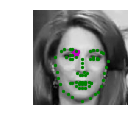

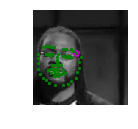

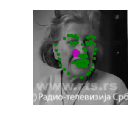

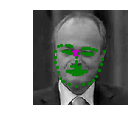

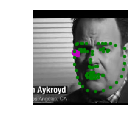

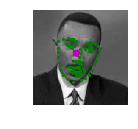

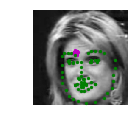

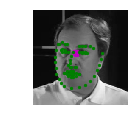

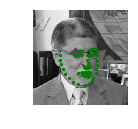

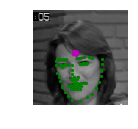

In [202]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.to('cpu').numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.to('cpu').numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts.to('cpu'))
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [203]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [204]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            images = images.to(device)
            key_pts = key_pts.to(device)
            
            # forward pass to get outputs
            output_pts = net(images)
            
#             # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [213]:
# train your network
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.00028450337052345276
Epoch: 1, Batch: 20, Avg. Loss: 0.0002939216373488307
Epoch: 1, Batch: 30, Avg. Loss: 0.00034314401168376206
Epoch: 1, Batch: 40, Avg. Loss: 0.00020323860179632903
Epoch: 1, Batch: 50, Avg. Loss: 0.000345847362652421
Epoch: 1, Batch: 60, Avg. Loss: 0.00020678707677870988
Epoch: 1, Batch: 70, Avg. Loss: 0.00023395864479243755
Epoch: 1, Batch: 80, Avg. Loss: 0.00022577174752950668
Epoch: 1, Batch: 90, Avg. Loss: 0.00016693104337900876
Epoch: 1, Batch: 100, Avg. Loss: 0.00014532764116302133
Epoch: 1, Batch: 110, Avg. Loss: 0.00018734101671725512
Epoch: 1, Batch: 120, Avg. Loss: 0.0001931365989148617
Epoch: 1, Batch: 130, Avg. Loss: 0.00034758203476667406
Epoch: 1, Batch: 140, Avg. Loss: 0.0002858607629314065
Epoch: 1, Batch: 150, Avg. Loss: 0.0003131443914026022
Epoch: 1, Batch: 160, Avg. Loss: 0.0003780629723332822
Epoch: 1, Batch: 170, Avg. Loss: 0.0001639840085990727
Epoch: 1, Batch: 180, Avg. Loss: 0.0001820237934589386
Epoch: 1, 

Epoch: 5, Batch: 130, Avg. Loss: 0.00032323909271508454
Epoch: 5, Batch: 140, Avg. Loss: 0.00019669667724519967
Epoch: 5, Batch: 150, Avg. Loss: 0.000161345761269331
Epoch: 5, Batch: 160, Avg. Loss: 0.00022519757784903049
Epoch: 5, Batch: 170, Avg. Loss: 0.00017068369686603545
Epoch: 5, Batch: 180, Avg. Loss: 0.00018148951511830092
Epoch: 5, Batch: 190, Avg. Loss: 0.0001871499428525567
Epoch: 5, Batch: 200, Avg. Loss: 0.0001361386524513364
Epoch: 5, Batch: 210, Avg. Loss: 0.00016626886650919915
Epoch: 5, Batch: 220, Avg. Loss: 0.00019737905729562045
Epoch: 5, Batch: 230, Avg. Loss: 0.0001536482349038124
Epoch: 5, Batch: 240, Avg. Loss: 0.0003463951088488102
Epoch: 5, Batch: 250, Avg. Loss: 0.0001600698437541723
Epoch: 5, Batch: 260, Avg. Loss: 0.0001598461987450719
Epoch: 5, Batch: 270, Avg. Loss: 0.0001616149740293622
Epoch: 5, Batch: 280, Avg. Loss: 0.00013835499808192254
Epoch: 5, Batch: 290, Avg. Loss: 0.00015860443096607924
Epoch: 5, Batch: 300, Avg. Loss: 0.00021531938668340446
E

Epoch: 9, Batch: 250, Avg. Loss: 0.00017341358959674835
Epoch: 9, Batch: 260, Avg. Loss: 0.00015906127635389566
Epoch: 9, Batch: 270, Avg. Loss: 0.00015247000474482775
Epoch: 9, Batch: 280, Avg. Loss: 0.00027437491342425347
Epoch: 9, Batch: 290, Avg. Loss: 0.00017609582608565688
Epoch: 9, Batch: 300, Avg. Loss: 0.00019697512686252594
Epoch: 9, Batch: 310, Avg. Loss: 0.00023034369200468062
Epoch: 9, Batch: 320, Avg. Loss: 0.00020252276305109262
Epoch: 9, Batch: 330, Avg. Loss: 0.00024751067254692315
Epoch: 9, Batch: 340, Avg. Loss: 0.00040279946010559795
Epoch: 10, Batch: 10, Avg. Loss: 0.0001724198190495372
Epoch: 10, Batch: 20, Avg. Loss: 0.0001895889164879918
Epoch: 10, Batch: 30, Avg. Loss: 0.00020629546139389277
Epoch: 10, Batch: 40, Avg. Loss: 0.0001850117240101099
Epoch: 10, Batch: 50, Avg. Loss: 0.00020567459892481565
Epoch: 10, Batch: 60, Avg. Loss: 0.00022398163191974163
Epoch: 10, Batch: 70, Avg. Loss: 0.00016087558772414924
Epoch: 10, Batch: 80, Avg. Loss: 0.0001807614769786

Epoch: 14, Batch: 10, Avg. Loss: 0.00018902937415987253
Epoch: 14, Batch: 20, Avg. Loss: 0.00022949119936674833
Epoch: 14, Batch: 30, Avg. Loss: 0.00015549375815317035
Epoch: 14, Batch: 40, Avg. Loss: 0.0004000119501724839
Epoch: 14, Batch: 50, Avg. Loss: 0.00016727713122963904
Epoch: 14, Batch: 60, Avg. Loss: 0.0002190434318035841
Epoch: 14, Batch: 70, Avg. Loss: 0.00015535279549658298
Epoch: 14, Batch: 80, Avg. Loss: 0.00017077570501714944
Epoch: 14, Batch: 90, Avg. Loss: 0.00018676296947523952
Epoch: 14, Batch: 100, Avg. Loss: 0.00019478338956832884
Epoch: 14, Batch: 110, Avg. Loss: 0.0002133396603167057
Epoch: 14, Batch: 120, Avg. Loss: 0.0001933558639138937
Epoch: 14, Batch: 130, Avg. Loss: 0.0002726120539009571
Epoch: 14, Batch: 140, Avg. Loss: 0.0002025021445006132
Epoch: 14, Batch: 150, Avg. Loss: 0.0001699164304882288
Epoch: 14, Batch: 160, Avg. Loss: 0.00019257716275751592
Epoch: 14, Batch: 170, Avg. Loss: 0.00016926842648535968
Epoch: 14, Batch: 180, Avg. Loss: 0.00018267768

Epoch: 18, Batch: 110, Avg. Loss: 0.00014781443029642104
Epoch: 18, Batch: 120, Avg. Loss: 0.0003558977907523513
Epoch: 18, Batch: 130, Avg. Loss: 0.00017348734382539987
Epoch: 18, Batch: 140, Avg. Loss: 0.00017328965663909913
Epoch: 18, Batch: 150, Avg. Loss: 0.0001449565258808434
Epoch: 18, Batch: 160, Avg. Loss: 0.00017203254252672195
Epoch: 18, Batch: 170, Avg. Loss: 0.00017638111673295499
Epoch: 18, Batch: 180, Avg. Loss: 0.00020077667292207478
Epoch: 18, Batch: 190, Avg. Loss: 0.00019939902517944575
Epoch: 18, Batch: 200, Avg. Loss: 0.00022957948502153158
Epoch: 18, Batch: 210, Avg. Loss: 0.00014939417131245135
Epoch: 18, Batch: 220, Avg. Loss: 0.00017910842690616846
Epoch: 18, Batch: 230, Avg. Loss: 0.00013292651902884246
Epoch: 18, Batch: 240, Avg. Loss: 0.00019732289854437112
Epoch: 18, Batch: 250, Avg. Loss: 0.00023271545302122832
Epoch: 18, Batch: 260, Avg. Loss: 0.00015840945951640605
Epoch: 18, Batch: 270, Avg. Loss: 0.00019170331675559283
Epoch: 18, Batch: 280, Avg. Loss:

Epoch: 22, Batch: 210, Avg. Loss: 0.00026053499057888984
Epoch: 22, Batch: 220, Avg. Loss: 0.00032348583731800317
Epoch: 22, Batch: 230, Avg. Loss: 0.00016447305865585805
Epoch: 22, Batch: 240, Avg. Loss: 0.00019845328386873005
Epoch: 22, Batch: 250, Avg. Loss: 0.0001553282402455807
Epoch: 22, Batch: 260, Avg. Loss: 0.0001605087537318468
Epoch: 22, Batch: 270, Avg. Loss: 0.00015716967917978763
Epoch: 22, Batch: 280, Avg. Loss: 0.00014583151321858167
Epoch: 22, Batch: 290, Avg. Loss: 0.0001719440035521984
Epoch: 22, Batch: 300, Avg. Loss: 0.00015819665230810642
Epoch: 22, Batch: 310, Avg. Loss: 0.00021010574977844954
Epoch: 22, Batch: 320, Avg. Loss: 0.0002505377121269703
Epoch: 22, Batch: 330, Avg. Loss: 0.00022419191151857375
Epoch: 22, Batch: 340, Avg. Loss: 0.0002126048132777214
Epoch: 23, Batch: 10, Avg. Loss: 0.0001606175759807229
Epoch: 23, Batch: 20, Avg. Loss: 0.0001995931100100279
Epoch: 23, Batch: 30, Avg. Loss: 0.00015764165902510286
Epoch: 23, Batch: 40, Avg. Loss: 0.000203

Epoch: 26, Batch: 300, Avg. Loss: 0.00024022435769438744
Epoch: 26, Batch: 310, Avg. Loss: 0.00026565171778202056
Epoch: 26, Batch: 320, Avg. Loss: 0.00021176498103886841
Epoch: 26, Batch: 330, Avg. Loss: 0.00017012756131589413
Epoch: 26, Batch: 340, Avg. Loss: 0.00017260802537202836
Epoch: 27, Batch: 10, Avg. Loss: 0.00016211128607392312
Epoch: 27, Batch: 20, Avg. Loss: 0.0001574796000495553
Epoch: 27, Batch: 30, Avg. Loss: 0.00013199745770543813
Epoch: 27, Batch: 40, Avg. Loss: 0.0001775909848511219
Epoch: 27, Batch: 50, Avg. Loss: 0.0002125902120023966
Epoch: 27, Batch: 60, Avg. Loss: 0.0004354122811928391
Epoch: 27, Batch: 70, Avg. Loss: 0.00021468932181596757
Epoch: 27, Batch: 80, Avg. Loss: 0.0002263449477031827
Epoch: 27, Batch: 90, Avg. Loss: 0.0002668778346851468
Epoch: 27, Batch: 100, Avg. Loss: 0.00017993990052491427
Epoch: 27, Batch: 110, Avg. Loss: 0.0002078581554815173
Epoch: 27, Batch: 120, Avg. Loss: 0.00020725856069475412
Epoch: 27, Batch: 130, Avg. Loss: 0.00023182102

Epoch: 31, Batch: 60, Avg. Loss: 0.00024568700045347213
Epoch: 31, Batch: 70, Avg. Loss: 0.00019724809750914574
Epoch: 31, Batch: 80, Avg. Loss: 0.00022109889145940543
Epoch: 31, Batch: 90, Avg. Loss: 0.0001758520482107997
Epoch: 31, Batch: 100, Avg. Loss: 0.000214793236926198
Epoch: 31, Batch: 110, Avg. Loss: 0.00012917761504650116
Epoch: 31, Batch: 120, Avg. Loss: 0.00013442206662148237
Epoch: 31, Batch: 130, Avg. Loss: 0.00019983533583581447
Epoch: 31, Batch: 140, Avg. Loss: 0.000179738842882216
Epoch: 31, Batch: 150, Avg. Loss: 0.0002756931260228157
Epoch: 31, Batch: 160, Avg. Loss: 0.00016788111440837382
Epoch: 31, Batch: 170, Avg. Loss: 0.00016876316070556642
Epoch: 31, Batch: 180, Avg. Loss: 0.00023767665680497885
Epoch: 31, Batch: 190, Avg. Loss: 0.0002594812819734216
Epoch: 31, Batch: 200, Avg. Loss: 0.00019722067657858134
Epoch: 31, Batch: 210, Avg. Loss: 0.0001635495228692889
Epoch: 31, Batch: 220, Avg. Loss: 0.000169254126958549
Epoch: 31, Batch: 230, Avg. Loss: 0.000173893

Epoch: 35, Batch: 160, Avg. Loss: 0.00017860449990257622
Epoch: 35, Batch: 170, Avg. Loss: 0.00014240274485200643
Epoch: 35, Batch: 180, Avg. Loss: 0.00044487436302006247
Epoch: 35, Batch: 190, Avg. Loss: 0.00022831287141889334
Epoch: 35, Batch: 200, Avg. Loss: 0.00017790433950722216
Epoch: 35, Batch: 210, Avg. Loss: 0.0002290707230567932
Epoch: 35, Batch: 220, Avg. Loss: 0.00025989910401403904
Epoch: 35, Batch: 230, Avg. Loss: 0.000303850406780839
Epoch: 35, Batch: 240, Avg. Loss: 0.00016868248023092748
Epoch: 35, Batch: 250, Avg. Loss: 0.00038533710595220326
Epoch: 35, Batch: 260, Avg. Loss: 0.00016385570820420982
Epoch: 35, Batch: 270, Avg. Loss: 0.00018930633086711168
Epoch: 35, Batch: 280, Avg. Loss: 0.00018905710708349942
Epoch: 35, Batch: 290, Avg. Loss: 0.00014724291814491154
Epoch: 35, Batch: 300, Avg. Loss: 0.0002012699730694294
Epoch: 35, Batch: 310, Avg. Loss: 0.0001648477828130126
Epoch: 35, Batch: 320, Avg. Loss: 0.00024161225836724043
Epoch: 35, Batch: 330, Avg. Loss: 0.

Epoch: 39, Batch: 250, Avg. Loss: 0.00019689253624528645
Epoch: 39, Batch: 260, Avg. Loss: 0.00017044250387698412
Epoch: 39, Batch: 270, Avg. Loss: 0.0001728350855410099
Epoch: 39, Batch: 280, Avg. Loss: 0.00018599082250148058
Epoch: 39, Batch: 290, Avg. Loss: 0.000508571014739573
Epoch: 39, Batch: 300, Avg. Loss: 0.000178456855006516
Epoch: 39, Batch: 310, Avg. Loss: 0.00017274506436660886
Epoch: 39, Batch: 320, Avg. Loss: 0.00018787242472171784
Epoch: 39, Batch: 330, Avg. Loss: 0.00016693243850022553
Epoch: 39, Batch: 340, Avg. Loss: 0.00024081016611307858
Epoch: 40, Batch: 10, Avg. Loss: 0.00019573452835902573
Epoch: 40, Batch: 20, Avg. Loss: 0.0004583944994956255
Epoch: 40, Batch: 30, Avg. Loss: 0.00020006160996854306
Epoch: 40, Batch: 40, Avg. Loss: 0.00016699119005352258
Epoch: 40, Batch: 50, Avg. Loss: 0.00018227703589946033
Epoch: 40, Batch: 60, Avg. Loss: 0.00019210127461701632
Epoch: 40, Batch: 70, Avg. Loss: 0.00018759884312748908
Epoch: 40, Batch: 80, Avg. Loss: 0.000381246

Epoch: 44, Batch: 10, Avg. Loss: 0.00013773773284628986
Epoch: 44, Batch: 20, Avg. Loss: 0.00022076388727873563
Epoch: 44, Batch: 30, Avg. Loss: 0.00044186124484986065
Epoch: 44, Batch: 40, Avg. Loss: 0.00017595150507986545
Epoch: 44, Batch: 50, Avg. Loss: 0.00017098721582442522
Epoch: 44, Batch: 60, Avg. Loss: 0.00016562770307064056
Epoch: 44, Batch: 70, Avg. Loss: 0.00014311026316136122
Epoch: 44, Batch: 80, Avg. Loss: 0.00040497431159019473
Epoch: 44, Batch: 90, Avg. Loss: 0.000170694453176111
Epoch: 44, Batch: 100, Avg. Loss: 0.00019293253123760224
Epoch: 44, Batch: 110, Avg. Loss: 0.00021150454226881264
Epoch: 44, Batch: 120, Avg. Loss: 0.00017290184088051319
Epoch: 44, Batch: 130, Avg. Loss: 0.00018997697439044714
Epoch: 44, Batch: 140, Avg. Loss: 0.0001335011515766382
Epoch: 44, Batch: 150, Avg. Loss: 0.0002443745629861951
Epoch: 44, Batch: 160, Avg. Loss: 0.00019363197218626738
Epoch: 44, Batch: 170, Avg. Loss: 0.0002104895794764161
Epoch: 44, Batch: 180, Avg. Loss: 0.000179625

Epoch: 48, Batch: 110, Avg. Loss: 0.00014800724759697913
Epoch: 48, Batch: 120, Avg. Loss: 0.00016443046741187572
Epoch: 48, Batch: 130, Avg. Loss: 0.00014409818686544895
Epoch: 48, Batch: 140, Avg. Loss: 0.00020007207617163658
Epoch: 48, Batch: 150, Avg. Loss: 0.00015750732738524674
Epoch: 48, Batch: 160, Avg. Loss: 0.00015286771208047867
Epoch: 48, Batch: 170, Avg. Loss: 0.00017292046640068293
Epoch: 48, Batch: 180, Avg. Loss: 0.0001567121697589755
Epoch: 48, Batch: 190, Avg. Loss: 0.00021642946731299163
Epoch: 48, Batch: 200, Avg. Loss: 0.00016830261051654815
Epoch: 48, Batch: 210, Avg. Loss: 0.00017037162836641074
Epoch: 48, Batch: 220, Avg. Loss: 0.00020232534129172565
Epoch: 48, Batch: 230, Avg. Loss: 0.00022520049382001163
Epoch: 48, Batch: 240, Avg. Loss: 0.00016187772899866105
Epoch: 48, Batch: 250, Avg. Loss: 0.00016012703208252788
Epoch: 48, Batch: 260, Avg. Loss: 0.00014705606549978256
Epoch: 48, Batch: 270, Avg. Loss: 0.0001768738254904747
Epoch: 48, Batch: 280, Avg. Loss:

Epoch: 52, Batch: 210, Avg. Loss: 0.00020717313326895238
Epoch: 52, Batch: 220, Avg. Loss: 0.00018104795552790164
Epoch: 52, Batch: 230, Avg. Loss: 0.00024283931870013476
Epoch: 52, Batch: 240, Avg. Loss: 0.0003681246461346746
Epoch: 52, Batch: 250, Avg. Loss: 0.0002605228601023555
Epoch: 52, Batch: 260, Avg. Loss: 0.00022303798235952853
Epoch: 52, Batch: 270, Avg. Loss: 0.00013989151269197463
Epoch: 52, Batch: 280, Avg. Loss: 0.0001988178864121437
Epoch: 52, Batch: 290, Avg. Loss: 0.00016822933359071613
Epoch: 52, Batch: 300, Avg. Loss: 0.00019165887404233218
Epoch: 52, Batch: 310, Avg. Loss: 0.0003584325956180692
Epoch: 52, Batch: 320, Avg. Loss: 0.00024876715987920764
Epoch: 52, Batch: 330, Avg. Loss: 0.0001882522525265813
Epoch: 52, Batch: 340, Avg. Loss: 0.00015601039491593838
Epoch: 53, Batch: 10, Avg. Loss: 0.0002343570366501808
Epoch: 53, Batch: 20, Avg. Loss: 0.00014045414328575135
Epoch: 53, Batch: 30, Avg. Loss: 0.00013122050371021032
Epoch: 53, Batch: 40, Avg. Loss: 0.00012

Epoch: 56, Batch: 310, Avg. Loss: 0.00014810857363045215
Epoch: 56, Batch: 320, Avg. Loss: 0.0001909198993816972
Epoch: 56, Batch: 330, Avg. Loss: 0.00017598522454500198
Epoch: 56, Batch: 340, Avg. Loss: 0.00020089598838239907
Epoch: 57, Batch: 10, Avg. Loss: 0.00021396523062139748
Epoch: 57, Batch: 20, Avg. Loss: 0.0001780167566612363
Epoch: 57, Batch: 30, Avg. Loss: 0.0005826669912785291
Epoch: 57, Batch: 40, Avg. Loss: 0.0003248753631487489
Epoch: 57, Batch: 50, Avg. Loss: 0.00023825227189809084
Epoch: 57, Batch: 60, Avg. Loss: 0.00020740665588527918
Epoch: 57, Batch: 70, Avg. Loss: 0.00014969172328710556
Epoch: 57, Batch: 80, Avg. Loss: 0.00018042750842869282
Epoch: 57, Batch: 90, Avg. Loss: 0.00019220346398651599
Epoch: 57, Batch: 100, Avg. Loss: 0.0002885658461600542
Epoch: 57, Batch: 110, Avg. Loss: 0.00021440296992659568
Epoch: 57, Batch: 120, Avg. Loss: 0.00018615385331213476
Epoch: 57, Batch: 130, Avg. Loss: 0.00020180869661271572
Epoch: 57, Batch: 140, Avg. Loss: 0.000148696

Epoch: 61, Batch: 70, Avg. Loss: 0.00015303476946428417
Epoch: 61, Batch: 80, Avg. Loss: 0.00020924412459135056
Epoch: 61, Batch: 90, Avg. Loss: 0.00016510870866477488
Epoch: 61, Batch: 100, Avg. Loss: 0.00018275837367400527
Epoch: 61, Batch: 110, Avg. Loss: 0.0001383160836994648
Epoch: 61, Batch: 120, Avg. Loss: 0.000169642168097198
Epoch: 61, Batch: 130, Avg. Loss: 0.00021142748929560185
Epoch: 61, Batch: 140, Avg. Loss: 0.00016778296884149312
Epoch: 61, Batch: 150, Avg. Loss: 0.00032749052718281747
Epoch: 61, Batch: 160, Avg. Loss: 0.000258467554114759
Epoch: 61, Batch: 170, Avg. Loss: 0.0001728231543675065
Epoch: 61, Batch: 180, Avg. Loss: 0.00021644461527466774
Epoch: 61, Batch: 190, Avg. Loss: 0.000169759564101696
Epoch: 61, Batch: 200, Avg. Loss: 0.00019495655316859484
Epoch: 61, Batch: 210, Avg. Loss: 0.0002032490144483745
Epoch: 61, Batch: 220, Avg. Loss: 0.00012872517853975297
Epoch: 61, Batch: 230, Avg. Loss: 0.0001848850641399622
Epoch: 61, Batch: 240, Avg. Loss: 0.00013271

Epoch: 65, Batch: 170, Avg. Loss: 0.0002527880915440619
Epoch: 65, Batch: 180, Avg. Loss: 0.00022147972881793977
Epoch: 65, Batch: 190, Avg. Loss: 0.0002745081475004554
Epoch: 65, Batch: 200, Avg. Loss: 0.0001556531758978963
Epoch: 65, Batch: 210, Avg. Loss: 0.00017716501373797654
Epoch: 65, Batch: 220, Avg. Loss: 0.00025433335639536383
Epoch: 65, Batch: 230, Avg. Loss: 0.00022330803982913494
Epoch: 65, Batch: 240, Avg. Loss: 0.00017278336593881248
Epoch: 65, Batch: 250, Avg. Loss: 0.00015671853814274074
Epoch: 65, Batch: 260, Avg. Loss: 0.00016866746544837952
Epoch: 65, Batch: 270, Avg. Loss: 0.0002312390599399805
Epoch: 65, Batch: 280, Avg. Loss: 0.00025306180864572526
Epoch: 65, Batch: 290, Avg. Loss: 0.00017342711286619307
Epoch: 65, Batch: 300, Avg. Loss: 0.0001714203031733632
Epoch: 65, Batch: 310, Avg. Loss: 0.00017543951887637378
Epoch: 65, Batch: 320, Avg. Loss: 0.0002054643677547574
Epoch: 65, Batch: 330, Avg. Loss: 0.0001934481542557478
Epoch: 65, Batch: 340, Avg. Loss: 0.00

Epoch: 69, Batch: 270, Avg. Loss: 0.00016833020374178886
Epoch: 69, Batch: 280, Avg. Loss: 0.0001689982172101736
Epoch: 69, Batch: 290, Avg. Loss: 0.00046937696542590857
Epoch: 69, Batch: 300, Avg. Loss: 0.00020862869266420603
Epoch: 69, Batch: 310, Avg. Loss: 0.0001795732043683529
Epoch: 69, Batch: 320, Avg. Loss: 0.00022025868110358716
Epoch: 69, Batch: 330, Avg. Loss: 0.00021622785832732915
Epoch: 69, Batch: 340, Avg. Loss: 0.0002427644394338131
Epoch: 70, Batch: 10, Avg. Loss: 0.00020629053190350532
Epoch: 70, Batch: 20, Avg. Loss: 0.00017231605295091868
Epoch: 70, Batch: 30, Avg. Loss: 0.0001643098657950759
Epoch: 70, Batch: 40, Avg. Loss: 0.0001358287539333105
Epoch: 70, Batch: 50, Avg. Loss: 0.00020002500526607037
Epoch: 70, Batch: 60, Avg. Loss: 0.0002995082922279835
Epoch: 70, Batch: 70, Avg. Loss: 0.00018523506075143815
Epoch: 70, Batch: 80, Avg. Loss: 0.00015707568544894458
Epoch: 70, Batch: 90, Avg. Loss: 0.00018076163670048117
Epoch: 70, Batch: 100, Avg. Loss: 0.0002528648

Epoch: 74, Batch: 30, Avg. Loss: 0.00015180982369929552
Epoch: 74, Batch: 40, Avg. Loss: 0.00022555952426046134
Epoch: 74, Batch: 50, Avg. Loss: 0.00014685477456077934
Epoch: 74, Batch: 60, Avg. Loss: 0.00025642906688153744
Epoch: 74, Batch: 70, Avg. Loss: 0.00020697755180299282
Epoch: 74, Batch: 80, Avg. Loss: 0.00024350800272077323
Epoch: 74, Batch: 90, Avg. Loss: 0.00017153054103255272
Epoch: 74, Batch: 100, Avg. Loss: 0.00017553800530731677
Epoch: 74, Batch: 110, Avg. Loss: 0.00017432340886443853
Epoch: 74, Batch: 120, Avg. Loss: 0.00021607712004333734
Epoch: 74, Batch: 130, Avg. Loss: 0.00015114622283726931
Epoch: 74, Batch: 140, Avg. Loss: 0.00022113916650414467
Epoch: 74, Batch: 150, Avg. Loss: 0.00017624675016850234
Epoch: 74, Batch: 160, Avg. Loss: 0.0001705780168995261
Epoch: 74, Batch: 170, Avg. Loss: 0.00020567229483276606
Epoch: 74, Batch: 180, Avg. Loss: 0.00023201919067651034
Epoch: 74, Batch: 190, Avg. Loss: 0.00020043661631643773
Epoch: 74, Batch: 200, Avg. Loss: 0.000

Epoch: 78, Batch: 130, Avg. Loss: 0.00017972593288868665
Epoch: 78, Batch: 140, Avg. Loss: 0.00019746427517384292
Epoch: 78, Batch: 150, Avg. Loss: 0.0001732038389891386
Epoch: 78, Batch: 160, Avg. Loss: 0.00020090211741626262
Epoch: 78, Batch: 170, Avg. Loss: 0.00017738851066678761
Epoch: 78, Batch: 180, Avg. Loss: 0.00015395589405670763
Epoch: 78, Batch: 190, Avg. Loss: 0.00014267495740205048
Epoch: 78, Batch: 200, Avg. Loss: 0.00015361075662076473
Epoch: 78, Batch: 210, Avg. Loss: 0.00013497412856668234
Epoch: 78, Batch: 220, Avg. Loss: 0.00019799775164574385
Epoch: 78, Batch: 230, Avg. Loss: 0.00019669699016958475
Epoch: 78, Batch: 240, Avg. Loss: 0.00015857819467782975
Epoch: 78, Batch: 250, Avg. Loss: 0.00018719107378274203
Epoch: 78, Batch: 260, Avg. Loss: 0.00019192605838179588
Epoch: 78, Batch: 270, Avg. Loss: 0.00014845121186226606
Epoch: 78, Batch: 280, Avg. Loss: 0.00014879177790135144
Epoch: 78, Batch: 290, Avg. Loss: 0.0001550396215170622
Epoch: 78, Batch: 300, Avg. Loss:

Epoch: 82, Batch: 230, Avg. Loss: 0.0001922997087240219
Epoch: 82, Batch: 240, Avg. Loss: 0.0001867115432396531
Epoch: 82, Batch: 250, Avg. Loss: 0.00017608403973281384
Epoch: 82, Batch: 260, Avg. Loss: 0.00016250011976808308
Epoch: 82, Batch: 270, Avg. Loss: 0.00016417847061529756
Epoch: 82, Batch: 280, Avg. Loss: 0.00013896962814033032
Epoch: 82, Batch: 290, Avg. Loss: 0.00018310438003391028
Epoch: 82, Batch: 300, Avg. Loss: 0.00017925097141414882
Epoch: 82, Batch: 310, Avg. Loss: 0.00030798839684575795
Epoch: 82, Batch: 320, Avg. Loss: 0.00021217458602041007
Epoch: 82, Batch: 330, Avg. Loss: 0.0002267086049541831
Epoch: 82, Batch: 340, Avg. Loss: 0.0003231114335358143
Epoch: 83, Batch: 10, Avg. Loss: 0.00015020038839429618
Epoch: 83, Batch: 20, Avg. Loss: 0.00013653907179832458
Epoch: 83, Batch: 30, Avg. Loss: 0.00016590669937431812
Epoch: 83, Batch: 40, Avg. Loss: 0.00015550314541906118
Epoch: 83, Batch: 50, Avg. Loss: 0.00015451192017644643
Epoch: 83, Batch: 60, Avg. Loss: 0.00016

Epoch: 86, Batch: 330, Avg. Loss: 0.0001581766474992037
Epoch: 86, Batch: 340, Avg. Loss: 0.00020338762924075127
Epoch: 87, Batch: 10, Avg. Loss: 0.0001418434353545308
Epoch: 87, Batch: 20, Avg. Loss: 0.0001460724985226989
Epoch: 87, Batch: 30, Avg. Loss: 0.0001815147688612342
Epoch: 87, Batch: 40, Avg. Loss: 0.00022018747963011264
Epoch: 87, Batch: 50, Avg. Loss: 0.0001377799129113555
Epoch: 87, Batch: 60, Avg. Loss: 0.00031282417196780443
Epoch: 87, Batch: 70, Avg. Loss: 0.00016121825482696294
Epoch: 87, Batch: 80, Avg. Loss: 0.00018348055146634579
Epoch: 87, Batch: 90, Avg. Loss: 0.00021466252859681846
Epoch: 87, Batch: 100, Avg. Loss: 0.00019460833771154284
Epoch: 87, Batch: 110, Avg. Loss: 0.0002225503334775567
Epoch: 87, Batch: 120, Avg. Loss: 0.00015843425318598747
Epoch: 87, Batch: 130, Avg. Loss: 0.00026615339890122416
Epoch: 87, Batch: 140, Avg. Loss: 0.0002530021714046597
Epoch: 87, Batch: 150, Avg. Loss: 0.0001768678268417716
Epoch: 87, Batch: 160, Avg. Loss: 0.000178873096

Epoch: 91, Batch: 90, Avg. Loss: 0.0004881193488836288
Epoch: 91, Batch: 100, Avg. Loss: 0.00018651449494063853
Epoch: 91, Batch: 110, Avg. Loss: 0.00026588939782232044
Epoch: 91, Batch: 120, Avg. Loss: 0.0001915748007595539
Epoch: 91, Batch: 130, Avg. Loss: 0.0003607436129823327
Epoch: 91, Batch: 140, Avg. Loss: 0.00021776828542351722
Epoch: 91, Batch: 150, Avg. Loss: 0.00017522089648991824
Epoch: 91, Batch: 160, Avg. Loss: 0.00020253447629511357
Epoch: 91, Batch: 170, Avg. Loss: 0.00015729950089007617
Epoch: 91, Batch: 180, Avg. Loss: 0.00017327066231518983
Epoch: 91, Batch: 190, Avg. Loss: 0.0002648611404001713
Epoch: 91, Batch: 200, Avg. Loss: 0.00016646975465118885
Epoch: 91, Batch: 210, Avg. Loss: 0.00015586461406201125
Epoch: 91, Batch: 220, Avg. Loss: 0.00015836030105128885
Epoch: 91, Batch: 230, Avg. Loss: 0.00018912016600370406
Epoch: 91, Batch: 240, Avg. Loss: 0.00022803637851029633
Epoch: 91, Batch: 250, Avg. Loss: 0.00018337558675557376
Epoch: 91, Batch: 260, Avg. Loss: 0.

Epoch: 95, Batch: 190, Avg. Loss: 0.0002911121742799878
Epoch: 95, Batch: 200, Avg. Loss: 0.0001309001687914133
Epoch: 95, Batch: 210, Avg. Loss: 0.00013685461273416877
Epoch: 95, Batch: 220, Avg. Loss: 0.00018785353749990464
Epoch: 95, Batch: 230, Avg. Loss: 0.00017152176704257727
Epoch: 95, Batch: 240, Avg. Loss: 0.0001454684170894325
Epoch: 95, Batch: 250, Avg. Loss: 0.00013652657624334098
Epoch: 95, Batch: 260, Avg. Loss: 0.00026003982312977316
Epoch: 95, Batch: 270, Avg. Loss: 0.00022870122734457255
Epoch: 95, Batch: 280, Avg. Loss: 0.00017595743015408517
Epoch: 95, Batch: 290, Avg. Loss: 0.00018815975915640592
Epoch: 95, Batch: 300, Avg. Loss: 0.00013446681946516036
Epoch: 95, Batch: 310, Avg. Loss: 0.00016647643968462943
Epoch: 95, Batch: 320, Avg. Loss: 0.00013706527836620808
Epoch: 95, Batch: 330, Avg. Loss: 0.00018434363044798373
Epoch: 95, Batch: 340, Avg. Loss: 0.00017877642251551152
Epoch: 96, Batch: 10, Avg. Loss: 0.00013711902312934398
Epoch: 96, Batch: 20, Avg. Loss: 0.

Epoch: 99, Batch: 280, Avg. Loss: 0.00016670780070126057
Epoch: 99, Batch: 290, Avg. Loss: 0.0001483683194965124
Epoch: 99, Batch: 300, Avg. Loss: 0.00021745385695248843
Epoch: 99, Batch: 310, Avg. Loss: 0.00019493323285132646
Epoch: 99, Batch: 320, Avg. Loss: 0.00016811974253505468
Epoch: 99, Batch: 330, Avg. Loss: 0.0001876934189349413
Epoch: 99, Batch: 340, Avg. Loss: 0.00019593002647161483
Epoch: 100, Batch: 10, Avg. Loss: 0.0001611377401277423
Epoch: 100, Batch: 20, Avg. Loss: 0.00014893906377255918
Epoch: 100, Batch: 30, Avg. Loss: 0.00013113216590136288
Epoch: 100, Batch: 40, Avg. Loss: 0.00016448497166857124
Epoch: 100, Batch: 50, Avg. Loss: 0.00015263937879353762
Epoch: 100, Batch: 60, Avg. Loss: 0.00014391837874427437
Epoch: 100, Batch: 70, Avg. Loss: 0.00015342135168612003
Epoch: 100, Batch: 80, Avg. Loss: 0.00035912925750017165
Epoch: 100, Batch: 90, Avg. Loss: 0.0001876326771453023
Epoch: 100, Batch: 100, Avg. Loss: 0.00013717675674706698
Epoch: 100, Batch: 110, Avg. Loss:

Epoch: 104, Batch: 10, Avg. Loss: 0.0001447951104491949
Epoch: 104, Batch: 20, Avg. Loss: 0.00014922774769365787
Epoch: 104, Batch: 30, Avg. Loss: 0.0001759951412677765
Epoch: 104, Batch: 40, Avg. Loss: 0.00014982312824577093
Epoch: 104, Batch: 50, Avg. Loss: 0.00013318090979009867
Epoch: 104, Batch: 60, Avg. Loss: 0.00017628788854926825
Epoch: 104, Batch: 70, Avg. Loss: 0.0001326677380129695
Epoch: 104, Batch: 80, Avg. Loss: 0.00020978112518787385
Epoch: 104, Batch: 90, Avg. Loss: 0.00018764819530770182
Epoch: 104, Batch: 100, Avg. Loss: 0.0001656975895166397
Epoch: 104, Batch: 110, Avg. Loss: 0.0002484711054712534
Epoch: 104, Batch: 120, Avg. Loss: 0.00022909264825284482
Epoch: 104, Batch: 130, Avg. Loss: 0.0002692994521930814
Epoch: 104, Batch: 140, Avg. Loss: 0.00019587421836331486
Epoch: 104, Batch: 150, Avg. Loss: 0.00023134540673345328
Epoch: 104, Batch: 160, Avg. Loss: 0.0001946848714724183
Epoch: 104, Batch: 170, Avg. Loss: 0.00017967686243355275
Epoch: 104, Batch: 180, Avg. L

Epoch: 108, Batch: 80, Avg. Loss: 0.00019951498415321113
Epoch: 108, Batch: 90, Avg. Loss: 0.00022293681651353836
Epoch: 108, Batch: 100, Avg. Loss: 0.00023441494069993495
Epoch: 108, Batch: 110, Avg. Loss: 0.0001970518883317709
Epoch: 108, Batch: 120, Avg. Loss: 0.00018825365137308835
Epoch: 108, Batch: 130, Avg. Loss: 0.00018007278069853783
Epoch: 108, Batch: 140, Avg. Loss: 0.00018678949307650327
Epoch: 108, Batch: 150, Avg. Loss: 0.00017934427503496408
Epoch: 108, Batch: 160, Avg. Loss: 0.00016694200783967973
Epoch: 108, Batch: 170, Avg. Loss: 0.00019827567366883158
Epoch: 108, Batch: 180, Avg. Loss: 0.00020749891363084315
Epoch: 108, Batch: 190, Avg. Loss: 0.0001834540097042918
Epoch: 108, Batch: 200, Avg. Loss: 0.0001885402435436845
Epoch: 108, Batch: 210, Avg. Loss: 0.00015698797162622214
Epoch: 108, Batch: 220, Avg. Loss: 0.00016509457025676966
Epoch: 108, Batch: 230, Avg. Loss: 0.00023266637045890094
Epoch: 108, Batch: 240, Avg. Loss: 0.00017678088042885065
Epoch: 108, Batch: 

Epoch: 112, Batch: 150, Avg. Loss: 0.00019835203513503074
Epoch: 112, Batch: 160, Avg. Loss: 0.00013208086136728525
Epoch: 112, Batch: 170, Avg. Loss: 0.000197605830617249
Epoch: 112, Batch: 180, Avg. Loss: 0.0002676841802895069
Epoch: 112, Batch: 190, Avg. Loss: 0.00019981508050113917
Epoch: 112, Batch: 200, Avg. Loss: 0.00014811847452074288
Epoch: 112, Batch: 210, Avg. Loss: 0.00035664975736290216
Epoch: 112, Batch: 220, Avg. Loss: 0.0001773778381757438
Epoch: 112, Batch: 230, Avg. Loss: 0.0002482696995139122
Epoch: 112, Batch: 240, Avg. Loss: 0.00015708569251000881
Epoch: 112, Batch: 250, Avg. Loss: 0.00021172621101140976
Epoch: 112, Batch: 260, Avg. Loss: 0.0001494596735574305
Epoch: 112, Batch: 270, Avg. Loss: 0.00020678217150270939
Epoch: 112, Batch: 280, Avg. Loss: 0.00023504980187863113
Epoch: 112, Batch: 290, Avg. Loss: 0.00015774716762825846
Epoch: 112, Batch: 300, Avg. Loss: 0.0001820027194917202
Epoch: 112, Batch: 310, Avg. Loss: 0.00022442090325057505
Epoch: 112, Batch: 32

Epoch: 116, Batch: 220, Avg. Loss: 0.00017691249586641788
Epoch: 116, Batch: 230, Avg. Loss: 0.00014857632759958505
Epoch: 116, Batch: 240, Avg. Loss: 0.00014344463869929314
Epoch: 116, Batch: 250, Avg. Loss: 0.00016884468914940952
Epoch: 116, Batch: 260, Avg. Loss: 0.00035139309521764516
Epoch: 116, Batch: 270, Avg. Loss: 0.0001615938199684024
Epoch: 116, Batch: 280, Avg. Loss: 0.0001622937060892582
Epoch: 116, Batch: 290, Avg. Loss: 0.00016980093065649271
Epoch: 116, Batch: 300, Avg. Loss: 0.00016780655086040498
Epoch: 116, Batch: 310, Avg. Loss: 0.00020332131441682576
Epoch: 116, Batch: 320, Avg. Loss: 0.00015801083389669655
Epoch: 116, Batch: 330, Avg. Loss: 0.0001499653197824955
Epoch: 116, Batch: 340, Avg. Loss: 0.00016405983921140432
Epoch: 117, Batch: 10, Avg. Loss: 0.0001413531992584467
Epoch: 117, Batch: 20, Avg. Loss: 0.00015342742763459682
Epoch: 117, Batch: 30, Avg. Loss: 0.00013321094587445258
Epoch: 117, Batch: 40, Avg. Loss: 0.00015841240994632244
Epoch: 117, Batch: 50,

Epoch: 120, Batch: 290, Avg. Loss: 0.00023795120092108847
Epoch: 120, Batch: 300, Avg. Loss: 0.00018995557818561793
Epoch: 120, Batch: 310, Avg. Loss: 0.00014197325240820647
Epoch: 120, Batch: 320, Avg. Loss: 0.00019100184878334403
Epoch: 120, Batch: 330, Avg. Loss: 0.00014516239520162344
Epoch: 120, Batch: 340, Avg. Loss: 0.00014023908646777273
Epoch: 121, Batch: 10, Avg. Loss: 0.00014102761819958688
Epoch: 121, Batch: 20, Avg. Loss: 0.00015905356965959072
Epoch: 121, Batch: 30, Avg. Loss: 0.00015470954682677985
Epoch: 121, Batch: 40, Avg. Loss: 0.00018965618964284658
Epoch: 121, Batch: 50, Avg. Loss: 0.00014475437719374895
Epoch: 121, Batch: 60, Avg. Loss: 0.00018296667095273734
Epoch: 121, Batch: 70, Avg. Loss: 0.0001959643419831991
Epoch: 121, Batch: 80, Avg. Loss: 0.000157976062502712
Epoch: 121, Batch: 90, Avg. Loss: 0.00022345367446541787
Epoch: 121, Batch: 100, Avg. Loss: 0.0001518512284383178
Epoch: 121, Batch: 110, Avg. Loss: 0.00017644771747291088
Epoch: 121, Batch: 120, Avg

Epoch: 125, Batch: 20, Avg. Loss: 0.00015530599653720855
Epoch: 125, Batch: 30, Avg. Loss: 0.00020452821254730226
Epoch: 125, Batch: 40, Avg. Loss: 0.00018388831429183482
Epoch: 125, Batch: 50, Avg. Loss: 0.00019806110858917238
Epoch: 125, Batch: 60, Avg. Loss: 0.0001797190997749567
Epoch: 125, Batch: 70, Avg. Loss: 0.00013277191016823053
Epoch: 125, Batch: 80, Avg. Loss: 0.0002249673008918762
Epoch: 125, Batch: 90, Avg. Loss: 0.00016665649972856045
Epoch: 125, Batch: 100, Avg. Loss: 0.00016933432687073945
Epoch: 125, Batch: 110, Avg. Loss: 0.0001338615701533854
Epoch: 125, Batch: 120, Avg. Loss: 0.00034587251581251623
Epoch: 125, Batch: 130, Avg. Loss: 0.0001855617305263877
Epoch: 125, Batch: 140, Avg. Loss: 0.0001610549334436655
Epoch: 125, Batch: 150, Avg. Loss: 0.00016014627553522586
Epoch: 125, Batch: 160, Avg. Loss: 0.0003425323613919318
Epoch: 125, Batch: 170, Avg. Loss: 0.00015686632227152587
Epoch: 125, Batch: 180, Avg. Loss: 0.00020949484780430794
Epoch: 125, Batch: 190, Avg.

Epoch: 129, Batch: 90, Avg. Loss: 0.0002080217245966196
Epoch: 129, Batch: 100, Avg. Loss: 0.00020532129984349013
Epoch: 129, Batch: 110, Avg. Loss: 0.000224304033908993
Epoch: 129, Batch: 120, Avg. Loss: 0.0001668746415525675
Epoch: 129, Batch: 130, Avg. Loss: 0.00013886003009974955
Epoch: 129, Batch: 140, Avg. Loss: 0.00016520476527512074
Epoch: 129, Batch: 150, Avg. Loss: 0.00022449382767081262
Epoch: 129, Batch: 160, Avg. Loss: 0.00015626449324190617
Epoch: 129, Batch: 170, Avg. Loss: 0.000159595993347466
Epoch: 129, Batch: 180, Avg. Loss: 0.0001853706184774637
Epoch: 129, Batch: 190, Avg. Loss: 0.00019070633221417665
Epoch: 129, Batch: 200, Avg. Loss: 0.00019877124298363924
Epoch: 129, Batch: 210, Avg. Loss: 0.00019269721489399672
Epoch: 129, Batch: 220, Avg. Loss: 0.00015934856608510018
Epoch: 129, Batch: 230, Avg. Loss: 0.00018904590513557195
Epoch: 129, Batch: 240, Avg. Loss: 0.00015574141778051853
Epoch: 129, Batch: 250, Avg. Loss: 0.00017236705776304008
Epoch: 129, Batch: 260

Epoch: 133, Batch: 160, Avg. Loss: 0.0001447346583008766
Epoch: 133, Batch: 170, Avg. Loss: 0.0002731181448325515
Epoch: 133, Batch: 180, Avg. Loss: 0.00016911151073873044
Epoch: 133, Batch: 190, Avg. Loss: 0.000194149075075984
Epoch: 133, Batch: 200, Avg. Loss: 0.00018537085503339768
Epoch: 133, Batch: 210, Avg. Loss: 0.0001532406648620963
Epoch: 133, Batch: 220, Avg. Loss: 0.00015323656518012284
Epoch: 133, Batch: 230, Avg. Loss: 0.00015606636088341474
Epoch: 133, Batch: 240, Avg. Loss: 0.00015899193380028008
Epoch: 133, Batch: 250, Avg. Loss: 0.0001538276756182313
Epoch: 133, Batch: 260, Avg. Loss: 0.0001753628421574831
Epoch: 133, Batch: 270, Avg. Loss: 0.00020750846993178128
Epoch: 133, Batch: 280, Avg. Loss: 0.000166046479716897
Epoch: 133, Batch: 290, Avg. Loss: 0.00016901963297277688
Epoch: 133, Batch: 300, Avg. Loss: 0.00022118226252496243
Epoch: 133, Batch: 310, Avg. Loss: 0.00014402472507208587
Epoch: 133, Batch: 320, Avg. Loss: 0.00022634532023221255
Epoch: 133, Batch: 330,

Epoch: 137, Batch: 230, Avg. Loss: 0.0001394695173949003
Epoch: 137, Batch: 240, Avg. Loss: 0.00014097620639950037
Epoch: 137, Batch: 250, Avg. Loss: 0.00017366283014416694
Epoch: 137, Batch: 260, Avg. Loss: 0.00016521067358553408
Epoch: 137, Batch: 270, Avg. Loss: 0.0001633460922166705
Epoch: 137, Batch: 280, Avg. Loss: 0.00013188023678958416
Epoch: 137, Batch: 290, Avg. Loss: 0.0001849370445124805
Epoch: 137, Batch: 300, Avg. Loss: 0.00020727462973445655
Epoch: 137, Batch: 310, Avg. Loss: 0.00014619832299649714
Epoch: 137, Batch: 320, Avg. Loss: 0.0001561227054335177
Epoch: 137, Batch: 330, Avg. Loss: 0.0001952285896986723
Epoch: 137, Batch: 340, Avg. Loss: 0.00023478028178215026
Epoch: 138, Batch: 10, Avg. Loss: 0.00018812126107513904
Epoch: 138, Batch: 20, Avg. Loss: 0.0001749784192070365
Epoch: 138, Batch: 30, Avg. Loss: 0.0001536297919228673
Epoch: 138, Batch: 40, Avg. Loss: 0.00017543943598866463
Epoch: 138, Batch: 50, Avg. Loss: 0.00015211110282689334
Epoch: 138, Batch: 60, Avg

Epoch: 141, Batch: 300, Avg. Loss: 0.00019463952723890543
Epoch: 141, Batch: 310, Avg. Loss: 0.00017424752470105887
Epoch: 141, Batch: 320, Avg. Loss: 0.00016780907288193702
Epoch: 141, Batch: 330, Avg. Loss: 0.00017287163063883781
Epoch: 141, Batch: 340, Avg. Loss: 0.00022797818668186665
Epoch: 142, Batch: 10, Avg. Loss: 0.00016180345695465803
Epoch: 142, Batch: 20, Avg. Loss: 0.00022962692845612765
Epoch: 142, Batch: 30, Avg. Loss: 0.0001514597861096263
Epoch: 142, Batch: 40, Avg. Loss: 0.0002439142121002078
Epoch: 142, Batch: 50, Avg. Loss: 0.00020886086206883193
Epoch: 142, Batch: 60, Avg. Loss: 0.00013871611375361681
Epoch: 142, Batch: 70, Avg. Loss: 0.0001760194869711995
Epoch: 142, Batch: 80, Avg. Loss: 0.00014378848345950247
Epoch: 142, Batch: 90, Avg. Loss: 0.00016629850585013627
Epoch: 142, Batch: 100, Avg. Loss: 0.00015576047822833062
Epoch: 142, Batch: 110, Avg. Loss: 0.0001698002154007554
Epoch: 142, Batch: 120, Avg. Loss: 0.00015784750320017336
Epoch: 142, Batch: 130, Avg

Epoch: 146, Batch: 30, Avg. Loss: 0.00015183832403272392
Epoch: 146, Batch: 40, Avg. Loss: 0.0001578632891178131
Epoch: 146, Batch: 50, Avg. Loss: 0.00013758675660938024
Epoch: 146, Batch: 60, Avg. Loss: 0.0001259356909431517
Epoch: 146, Batch: 70, Avg. Loss: 0.0005071002524346113
Epoch: 146, Batch: 80, Avg. Loss: 0.0002050740448758006
Epoch: 146, Batch: 90, Avg. Loss: 0.0001905562039464712
Epoch: 146, Batch: 100, Avg. Loss: 0.00018337551970034837
Epoch: 146, Batch: 110, Avg. Loss: 0.00015838018897920846
Epoch: 146, Batch: 120, Avg. Loss: 0.0002534533953294158
Epoch: 146, Batch: 130, Avg. Loss: 0.0001512983338907361
Epoch: 146, Batch: 140, Avg. Loss: 0.00020553654152899982
Epoch: 146, Batch: 150, Avg. Loss: 0.00017209894303232433
Epoch: 146, Batch: 160, Avg. Loss: 0.00017701012501493096
Epoch: 146, Batch: 170, Avg. Loss: 0.0001752486042678356
Epoch: 146, Batch: 180, Avg. Loss: 0.00016876826155930757
Epoch: 146, Batch: 190, Avg. Loss: 0.0002228309754282236
Epoch: 146, Batch: 200, Avg. L

Epoch: 150, Batch: 100, Avg. Loss: 0.00020943519845604896
Epoch: 150, Batch: 110, Avg. Loss: 0.0001651624673977494
Epoch: 150, Batch: 120, Avg. Loss: 0.00013993622921407224
Epoch: 150, Batch: 130, Avg. Loss: 0.0002888546157628298
Epoch: 150, Batch: 140, Avg. Loss: 0.00012434019101783633
Epoch: 150, Batch: 150, Avg. Loss: 0.000147998652420938
Epoch: 150, Batch: 160, Avg. Loss: 0.000192449226975441
Epoch: 150, Batch: 170, Avg. Loss: 0.00026638719718903304
Epoch: 150, Batch: 180, Avg. Loss: 0.00021771031152456998
Epoch: 150, Batch: 190, Avg. Loss: 0.00020033432729542255
Epoch: 150, Batch: 200, Avg. Loss: 0.0001674370774999261
Epoch: 150, Batch: 210, Avg. Loss: 0.00015964309219270944
Epoch: 150, Batch: 220, Avg. Loss: 0.00017211184278130532
Epoch: 150, Batch: 230, Avg. Loss: 0.0001430723387748003
Epoch: 150, Batch: 240, Avg. Loss: 0.0002593391067348421
Epoch: 150, Batch: 250, Avg. Loss: 0.0002038115793839097
Epoch: 150, Batch: 260, Avg. Loss: 0.00016925416607409716
Epoch: 150, Batch: 270, 

Epoch: 154, Batch: 170, Avg. Loss: 0.00020121446158736944
Epoch: 154, Batch: 180, Avg. Loss: 0.000336588965728879
Epoch: 154, Batch: 190, Avg. Loss: 0.00018178417067974805
Epoch: 154, Batch: 200, Avg. Loss: 0.00023661552742123605
Epoch: 154, Batch: 210, Avg. Loss: 0.0001721473867073655
Epoch: 154, Batch: 220, Avg. Loss: 0.0002733119344338775
Epoch: 154, Batch: 230, Avg. Loss: 0.00017558480706065892
Epoch: 154, Batch: 240, Avg. Loss: 0.0001512357583269477
Epoch: 154, Batch: 250, Avg. Loss: 0.00013959807530045508
Epoch: 154, Batch: 260, Avg. Loss: 0.00015617680782452226
Epoch: 154, Batch: 270, Avg. Loss: 0.00012681735400110484
Epoch: 154, Batch: 280, Avg. Loss: 0.00015925458213314413
Epoch: 154, Batch: 290, Avg. Loss: 0.00015785980317741633
Epoch: 154, Batch: 300, Avg. Loss: 0.00014441272895783185
Epoch: 154, Batch: 310, Avg. Loss: 0.00018986729625612497
Epoch: 154, Batch: 320, Avg. Loss: 0.00016605606675148011
Epoch: 154, Batch: 330, Avg. Loss: 0.00019993017613887786
Epoch: 154, Batch: 

Epoch: 158, Batch: 240, Avg. Loss: 0.00018753292877227067
Epoch: 158, Batch: 250, Avg. Loss: 0.00025598218850791455
Epoch: 158, Batch: 260, Avg. Loss: 0.00018052359484136104
Epoch: 158, Batch: 270, Avg. Loss: 0.0003087448365986347
Epoch: 158, Batch: 280, Avg. Loss: 0.00023454796988517046
Epoch: 158, Batch: 290, Avg. Loss: 0.00030132396472617984
Epoch: 158, Batch: 300, Avg. Loss: 0.00014778403472155333
Epoch: 158, Batch: 310, Avg. Loss: 0.0001546888556331396
Epoch: 158, Batch: 320, Avg. Loss: 0.00017008569184690715
Epoch: 158, Batch: 330, Avg. Loss: 0.0002240580450743437
Epoch: 158, Batch: 340, Avg. Loss: 0.0002275073667988181
Epoch: 159, Batch: 10, Avg. Loss: 0.00015208935365080835
Epoch: 159, Batch: 20, Avg. Loss: 0.0001363285416737199
Epoch: 159, Batch: 30, Avg. Loss: 0.00019910711888223887
Epoch: 159, Batch: 40, Avg. Loss: 0.00012761956360191106
Epoch: 159, Batch: 50, Avg. Loss: 0.00016015650145709514
Epoch: 159, Batch: 60, Avg. Loss: 0.00020254404284060002
Epoch: 159, Batch: 70, Av

Epoch: 162, Batch: 310, Avg. Loss: 0.00018498713709414006
Epoch: 162, Batch: 320, Avg. Loss: 0.0001405437821522355
Epoch: 162, Batch: 330, Avg. Loss: 0.00014343901025131345
Epoch: 162, Batch: 340, Avg. Loss: 0.00019468181766569615
Epoch: 163, Batch: 10, Avg. Loss: 0.00013728864397853614
Epoch: 163, Batch: 20, Avg. Loss: 0.00015397223085165024
Epoch: 163, Batch: 30, Avg. Loss: 0.00017134710028767587
Epoch: 163, Batch: 40, Avg. Loss: 0.00016220722161233426
Epoch: 163, Batch: 50, Avg. Loss: 0.00016922447085380554
Epoch: 163, Batch: 60, Avg. Loss: 0.00014380082674324512
Epoch: 163, Batch: 70, Avg. Loss: 0.00016599537432193757
Epoch: 163, Batch: 80, Avg. Loss: 0.00016884819231927396
Epoch: 163, Batch: 90, Avg. Loss: 0.00017322265822440386
Epoch: 163, Batch: 100, Avg. Loss: 0.0001456831730902195
Epoch: 163, Batch: 110, Avg. Loss: 0.00018076071422547103
Epoch: 163, Batch: 120, Avg. Loss: 0.00020337309176102282
Epoch: 163, Batch: 130, Avg. Loss: 0.0001882480625063181
Epoch: 163, Batch: 140, Av

Epoch: 167, Batch: 40, Avg. Loss: 0.00016567560750991106
Epoch: 167, Batch: 50, Avg. Loss: 0.0001610267022624612
Epoch: 167, Batch: 60, Avg. Loss: 0.00015985068026930094
Epoch: 167, Batch: 70, Avg. Loss: 0.00020288253389298916
Epoch: 167, Batch: 80, Avg. Loss: 0.0001464689252898097
Epoch: 167, Batch: 90, Avg. Loss: 0.00019196237809956075
Epoch: 167, Batch: 100, Avg. Loss: 0.00016680239140987396
Epoch: 167, Batch: 110, Avg. Loss: 0.00018191368971019983
Epoch: 167, Batch: 120, Avg. Loss: 0.0001619528946466744
Epoch: 167, Batch: 130, Avg. Loss: 0.000173876884393394
Epoch: 167, Batch: 140, Avg. Loss: 0.0002324552917852998
Epoch: 167, Batch: 150, Avg. Loss: 0.00019578496366739272
Epoch: 167, Batch: 160, Avg. Loss: 0.0002042481070384383
Epoch: 167, Batch: 170, Avg. Loss: 0.0001989256674423814
Epoch: 167, Batch: 180, Avg. Loss: 0.0002294845087453723
Epoch: 167, Batch: 190, Avg. Loss: 0.0002038001287728548
Epoch: 167, Batch: 200, Avg. Loss: 0.0005632933285087347
Epoch: 167, Batch: 210, Avg. Lo

Epoch: 171, Batch: 110, Avg. Loss: 0.00013586242683231832
Epoch: 171, Batch: 120, Avg. Loss: 0.00018279751390218736
Epoch: 171, Batch: 130, Avg. Loss: 0.0001757579753175378
Epoch: 171, Batch: 140, Avg. Loss: 0.000143578021787107
Epoch: 171, Batch: 150, Avg. Loss: 0.0001376748848706484
Epoch: 171, Batch: 160, Avg. Loss: 0.00016323797963559627
Epoch: 171, Batch: 170, Avg. Loss: 0.0003231891542673111
Epoch: 171, Batch: 180, Avg. Loss: 0.00018020337633788586
Epoch: 171, Batch: 190, Avg. Loss: 0.00017702000215649605
Epoch: 171, Batch: 200, Avg. Loss: 0.00015504833776503802
Epoch: 171, Batch: 210, Avg. Loss: 0.00017563209868967533
Epoch: 171, Batch: 220, Avg. Loss: 0.00019169920403510333
Epoch: 171, Batch: 230, Avg. Loss: 0.00013249545311555267
Epoch: 171, Batch: 240, Avg. Loss: 0.00015071685425937175
Epoch: 171, Batch: 250, Avg. Loss: 0.00014561455277726053
Epoch: 171, Batch: 260, Avg. Loss: 0.00015626859664916992
Epoch: 171, Batch: 270, Avg. Loss: 0.00015600938722491265
Epoch: 171, Batch: 

Epoch: 175, Batch: 180, Avg. Loss: 0.00016096168523654342
Epoch: 175, Batch: 190, Avg. Loss: 0.00019263748172670603
Epoch: 175, Batch: 200, Avg. Loss: 0.00019830037094652653
Epoch: 175, Batch: 210, Avg. Loss: 0.00019455564860254527
Epoch: 175, Batch: 220, Avg. Loss: 0.0001446556062437594
Epoch: 175, Batch: 230, Avg. Loss: 0.00017669885605573653
Epoch: 175, Batch: 240, Avg. Loss: 0.00017397490330040455
Epoch: 175, Batch: 250, Avg. Loss: 0.00019059852976351978
Epoch: 175, Batch: 260, Avg. Loss: 0.00017954005347564818
Epoch: 175, Batch: 270, Avg. Loss: 0.0003308899877592921
Epoch: 175, Batch: 280, Avg. Loss: 0.00017677713930606842
Epoch: 175, Batch: 290, Avg. Loss: 0.00014755965722724795
Epoch: 175, Batch: 300, Avg. Loss: 0.0001883265245705843
Epoch: 175, Batch: 310, Avg. Loss: 0.0001705933529883623
Epoch: 175, Batch: 320, Avg. Loss: 0.00020007555233314634
Epoch: 175, Batch: 330, Avg. Loss: 0.00018517943751066924
Epoch: 175, Batch: 340, Avg. Loss: 0.00016297884844243527
Epoch: 176, Batch:

Epoch: 179, Batch: 250, Avg. Loss: 0.00014398354012519122
Epoch: 179, Batch: 260, Avg. Loss: 0.00015963139757514
Epoch: 179, Batch: 270, Avg. Loss: 0.00015254449378699063
Epoch: 179, Batch: 280, Avg. Loss: 0.00015876630926504732
Epoch: 179, Batch: 290, Avg. Loss: 0.00018904392654076218
Epoch: 179, Batch: 300, Avg. Loss: 0.00016988577973097563
Epoch: 179, Batch: 310, Avg. Loss: 0.00017783268168568612
Epoch: 179, Batch: 320, Avg. Loss: 0.0001858007777482271
Epoch: 179, Batch: 330, Avg. Loss: 0.00017248083837330343
Epoch: 179, Batch: 340, Avg. Loss: 0.00023199340794235467
Epoch: 180, Batch: 10, Avg. Loss: 0.0001716059595346451
Epoch: 180, Batch: 20, Avg. Loss: 0.00033049833215773104
Epoch: 180, Batch: 30, Avg. Loss: 0.0001376495664007962
Epoch: 180, Batch: 40, Avg. Loss: 0.0001585463974624872
Epoch: 180, Batch: 50, Avg. Loss: 0.000165366992354393
Epoch: 180, Batch: 60, Avg. Loss: 0.00013289130479097365
Epoch: 180, Batch: 70, Avg. Loss: 0.00013738126773387194
Epoch: 180, Batch: 80, Avg. Lo

Epoch: 183, Batch: 320, Avg. Loss: 0.00019310524594038725
Epoch: 183, Batch: 330, Avg. Loss: 0.00023069594148546457
Epoch: 183, Batch: 340, Avg. Loss: 0.00017460557632148266
Epoch: 184, Batch: 10, Avg. Loss: 0.00015827595721930267
Epoch: 184, Batch: 20, Avg. Loss: 0.00013354217354208232
Epoch: 184, Batch: 30, Avg. Loss: 0.00015288730198517443
Epoch: 184, Batch: 40, Avg. Loss: 0.0001377881020307541
Epoch: 184, Batch: 50, Avg. Loss: 0.0002208922356367111
Epoch: 184, Batch: 60, Avg. Loss: 0.00020908251684159041
Epoch: 184, Batch: 70, Avg. Loss: 0.0001483670547604561
Epoch: 184, Batch: 80, Avg. Loss: 0.00014765315502882003
Epoch: 184, Batch: 90, Avg. Loss: 0.00026869964599609376
Epoch: 184, Batch: 100, Avg. Loss: 0.00015991501556709408
Epoch: 184, Batch: 110, Avg. Loss: 0.00019816836435347795
Epoch: 184, Batch: 120, Avg. Loss: 0.0003070756569504738
Epoch: 184, Batch: 130, Avg. Loss: 0.000174335983581841
Epoch: 184, Batch: 140, Avg. Loss: 0.00017809466645121575
Epoch: 184, Batch: 150, Avg. 

Epoch: 188, Batch: 50, Avg. Loss: 0.00014026324823498726
Epoch: 188, Batch: 60, Avg. Loss: 0.00017300272965803742
Epoch: 188, Batch: 70, Avg. Loss: 0.00015020900452509522
Epoch: 188, Batch: 80, Avg. Loss: 0.00018740014173090457
Epoch: 188, Batch: 90, Avg. Loss: 0.00021265143062919377
Epoch: 188, Batch: 100, Avg. Loss: 0.00015359398629516364
Epoch: 188, Batch: 110, Avg. Loss: 0.00025665801204741
Epoch: 188, Batch: 120, Avg. Loss: 0.00019305256567895413
Epoch: 188, Batch: 130, Avg. Loss: 0.00019059691857546568
Epoch: 188, Batch: 140, Avg. Loss: 0.00018245457205921412
Epoch: 188, Batch: 150, Avg. Loss: 0.0001555324262008071
Epoch: 188, Batch: 160, Avg. Loss: 0.00021855500573292374
Epoch: 188, Batch: 170, Avg. Loss: 0.00016974602080881596
Epoch: 188, Batch: 180, Avg. Loss: 0.0002047088099643588
Epoch: 188, Batch: 190, Avg. Loss: 0.00016316341515630484
Epoch: 188, Batch: 200, Avg. Loss: 0.00019250702671706676
Epoch: 188, Batch: 210, Avg. Loss: 0.00014218353386968375
Epoch: 188, Batch: 220, 

Epoch: 192, Batch: 120, Avg. Loss: 0.00018195131607353688
Epoch: 192, Batch: 130, Avg. Loss: 0.00023243653122335673
Epoch: 192, Batch: 140, Avg. Loss: 0.00017049384210258723
Epoch: 192, Batch: 150, Avg. Loss: 0.0001645598947070539
Epoch: 192, Batch: 160, Avg. Loss: 0.00014024326857179403
Epoch: 192, Batch: 170, Avg. Loss: 0.0002600173195824027
Epoch: 192, Batch: 180, Avg. Loss: 0.0002837327718734741
Epoch: 192, Batch: 190, Avg. Loss: 0.00024644254334270957
Epoch: 192, Batch: 200, Avg. Loss: 0.00021922829747200013
Epoch: 192, Batch: 210, Avg. Loss: 0.00022119558881968259
Epoch: 192, Batch: 220, Avg. Loss: 0.00018466483801603316
Epoch: 192, Batch: 230, Avg. Loss: 0.0001554071083664894
Epoch: 192, Batch: 240, Avg. Loss: 0.0001705066477879882
Epoch: 192, Batch: 250, Avg. Loss: 0.00011496900487691164
Epoch: 192, Batch: 260, Avg. Loss: 0.0001663408996537328
Epoch: 192, Batch: 270, Avg. Loss: 0.00023611770290881396
Epoch: 192, Batch: 280, Avg. Loss: 0.0001345043247565627
Epoch: 192, Batch: 29

Epoch: 196, Batch: 190, Avg. Loss: 0.00018061812408268451
Epoch: 196, Batch: 200, Avg. Loss: 0.00015439105127006768
Epoch: 196, Batch: 210, Avg. Loss: 0.00016019700840115547
Epoch: 196, Batch: 220, Avg. Loss: 0.00012754649855196477
Epoch: 196, Batch: 230, Avg. Loss: 0.00015889840293675661
Epoch: 196, Batch: 240, Avg. Loss: 0.00014176845829933882
Epoch: 196, Batch: 250, Avg. Loss: 0.0001372468750923872
Epoch: 196, Batch: 260, Avg. Loss: 0.00014506733696907759
Epoch: 196, Batch: 270, Avg. Loss: 0.00015196912828832864
Epoch: 196, Batch: 280, Avg. Loss: 0.00014822938293218612
Epoch: 196, Batch: 290, Avg. Loss: 0.00015311051066964866
Epoch: 196, Batch: 300, Avg. Loss: 0.00020430502016097307
Epoch: 196, Batch: 310, Avg. Loss: 0.00017263319110497833
Epoch: 196, Batch: 320, Avg. Loss: 0.0001634995797649026
Epoch: 196, Batch: 330, Avg. Loss: 0.0003883011722937226
Epoch: 196, Batch: 340, Avg. Loss: 0.00017677684500813485
Epoch: 197, Batch: 10, Avg. Loss: 0.00013855986576527356
Epoch: 197, Batch:

Epoch: 200, Batch: 260, Avg. Loss: 0.00013573261350393297
Epoch: 200, Batch: 270, Avg. Loss: 0.0001315883775241673
Epoch: 200, Batch: 280, Avg. Loss: 0.00018986062053591012
Epoch: 200, Batch: 290, Avg. Loss: 0.00016610847972333432
Epoch: 200, Batch: 300, Avg. Loss: 0.0001766712311655283
Epoch: 200, Batch: 310, Avg. Loss: 0.00015263808984309436
Epoch: 200, Batch: 320, Avg. Loss: 0.00026493368204683065
Epoch: 200, Batch: 330, Avg. Loss: 0.00017901473212987186
Epoch: 200, Batch: 340, Avg. Loss: 0.00019791249372065066
Epoch: 201, Batch: 10, Avg. Loss: 0.00012669542897492648
Epoch: 201, Batch: 20, Avg. Loss: 0.00015500150434672832
Epoch: 201, Batch: 30, Avg. Loss: 0.00014283970929682255
Epoch: 201, Batch: 40, Avg. Loss: 0.0001504831537604332
Epoch: 201, Batch: 50, Avg. Loss: 0.00014928220491856336
Epoch: 201, Batch: 60, Avg. Loss: 0.00016946327779442073
Epoch: 201, Batch: 70, Avg. Loss: 0.0001525518107227981
Epoch: 201, Batch: 80, Avg. Loss: 0.00019166605081409217
Epoch: 201, Batch: 90, Avg

Epoch: 204, Batch: 330, Avg. Loss: 0.00017843192908912898
Epoch: 204, Batch: 340, Avg. Loss: 0.00016328278183937072
Epoch: 205, Batch: 10, Avg. Loss: 0.00015023529902100563
Epoch: 205, Batch: 20, Avg. Loss: 0.00028131550550460814
Epoch: 205, Batch: 30, Avg. Loss: 0.0001421565068885684
Epoch: 205, Batch: 40, Avg. Loss: 0.00016765306424349545
Epoch: 205, Batch: 50, Avg. Loss: 0.0001601088624447584
Epoch: 205, Batch: 60, Avg. Loss: 0.00013551563303917648
Epoch: 205, Batch: 70, Avg. Loss: 0.00016595929861068726
Epoch: 205, Batch: 80, Avg. Loss: 0.00014257715549319982
Epoch: 205, Batch: 90, Avg. Loss: 0.0001848093578591943
Epoch: 205, Batch: 100, Avg. Loss: 0.00026451884023845194
Epoch: 205, Batch: 110, Avg. Loss: 0.00022083453647792339
Epoch: 205, Batch: 120, Avg. Loss: 0.00016160346334800123
Epoch: 205, Batch: 130, Avg. Loss: 0.00017257162462919952
Epoch: 205, Batch: 140, Avg. Loss: 0.00036904990952461956
Epoch: 205, Batch: 150, Avg. Loss: 0.000256714572198689
Epoch: 205, Batch: 160, Avg.

Epoch: 209, Batch: 60, Avg. Loss: 0.000252724071033299
Epoch: 209, Batch: 70, Avg. Loss: 0.00016445752512663604
Epoch: 209, Batch: 80, Avg. Loss: 0.00022291393484920265
Epoch: 209, Batch: 90, Avg. Loss: 0.00017730833170935512
Epoch: 209, Batch: 100, Avg. Loss: 0.00015100197587162255
Epoch: 209, Batch: 110, Avg. Loss: 0.00017156980838626624
Epoch: 209, Batch: 120, Avg. Loss: 0.00013790664076805114
Epoch: 209, Batch: 130, Avg. Loss: 0.0001478531714528799
Epoch: 209, Batch: 140, Avg. Loss: 0.00019101834623143078
Epoch: 209, Batch: 150, Avg. Loss: 0.00012497991835698486
Epoch: 209, Batch: 160, Avg. Loss: 0.00030951361078768966
Epoch: 209, Batch: 170, Avg. Loss: 0.00016152993869036436
Epoch: 209, Batch: 180, Avg. Loss: 0.00030853864084929227
Epoch: 209, Batch: 190, Avg. Loss: 0.00021916896663606167
Epoch: 209, Batch: 200, Avg. Loss: 0.00014771358761936427
Epoch: 209, Batch: 210, Avg. Loss: 0.0001423956314101815
Epoch: 209, Batch: 220, Avg. Loss: 0.0001588372653350234
Epoch: 209, Batch: 230,

Epoch: 213, Batch: 130, Avg. Loss: 0.00014131840132176876
Epoch: 213, Batch: 140, Avg. Loss: 0.00023040157742798328
Epoch: 213, Batch: 150, Avg. Loss: 0.00025165816955268383
Epoch: 213, Batch: 160, Avg. Loss: 0.00022810879070311784
Epoch: 213, Batch: 170, Avg. Loss: 0.00017179849278181793
Epoch: 213, Batch: 180, Avg. Loss: 0.000200457482598722
Epoch: 213, Batch: 190, Avg. Loss: 0.0001598599161952734
Epoch: 213, Batch: 200, Avg. Loss: 0.00018448466807603837
Epoch: 213, Batch: 210, Avg. Loss: 0.00019426767155528068
Epoch: 213, Batch: 220, Avg. Loss: 0.00019801639812067152
Epoch: 213, Batch: 230, Avg. Loss: 0.00020423485711216927
Epoch: 213, Batch: 240, Avg. Loss: 0.00017016227729618549
Epoch: 213, Batch: 250, Avg. Loss: 0.0001599712995812297
Epoch: 213, Batch: 260, Avg. Loss: 0.00013472981285303831
Epoch: 213, Batch: 270, Avg. Loss: 0.0001477368250489235
Epoch: 213, Batch: 280, Avg. Loss: 0.00017045493982732296
Epoch: 213, Batch: 290, Avg. Loss: 0.00017456306982785463
Epoch: 213, Batch: 

Epoch: 217, Batch: 200, Avg. Loss: 0.00020070057827979327
Epoch: 217, Batch: 210, Avg. Loss: 0.00017760989535599948
Epoch: 217, Batch: 220, Avg. Loss: 0.00014167410880327224
Epoch: 217, Batch: 230, Avg. Loss: 0.00015483334474265575
Epoch: 217, Batch: 240, Avg. Loss: 0.00014805632270872593
Epoch: 217, Batch: 250, Avg. Loss: 0.0001705540851689875
Epoch: 217, Batch: 260, Avg. Loss: 0.00020776088815182447
Epoch: 217, Batch: 270, Avg. Loss: 0.00015122376196086406
Epoch: 217, Batch: 280, Avg. Loss: 0.00017416626680642367
Epoch: 217, Batch: 290, Avg. Loss: 0.0001478214026428759
Epoch: 217, Batch: 300, Avg. Loss: 0.00018663527257740497
Epoch: 217, Batch: 310, Avg. Loss: 0.00017061858717352151
Epoch: 217, Batch: 320, Avg. Loss: 0.00014009604509919883
Epoch: 217, Batch: 330, Avg. Loss: 0.0001610013945028186
Epoch: 217, Batch: 340, Avg. Loss: 0.00019149880670011043
Epoch: 218, Batch: 10, Avg. Loss: 0.0001214635893702507
Epoch: 218, Batch: 20, Avg. Loss: 0.0001412104098126292
Epoch: 218, Batch: 30

Epoch: 221, Batch: 270, Avg. Loss: 0.00016873318795114755
Epoch: 221, Batch: 280, Avg. Loss: 0.00016450442746281625
Epoch: 221, Batch: 290, Avg. Loss: 0.0001939328834414482
Epoch: 221, Batch: 300, Avg. Loss: 0.00017761259945109486
Epoch: 221, Batch: 310, Avg. Loss: 0.00017412875965237617
Epoch: 221, Batch: 320, Avg. Loss: 0.00019147570244967938
Epoch: 221, Batch: 330, Avg. Loss: 0.0001867419248446822
Epoch: 221, Batch: 340, Avg. Loss: 0.0001551396520808339
Epoch: 222, Batch: 10, Avg. Loss: 0.00014409394189715386
Epoch: 222, Batch: 20, Avg. Loss: 0.00014564818888902664
Epoch: 222, Batch: 30, Avg. Loss: 0.00013473118655383588
Epoch: 222, Batch: 40, Avg. Loss: 0.00018030689377337696
Epoch: 222, Batch: 50, Avg. Loss: 0.0001414606934413314
Epoch: 222, Batch: 60, Avg. Loss: 0.0001449167812243104
Epoch: 222, Batch: 70, Avg. Loss: 0.0001548576047644019
Epoch: 222, Batch: 80, Avg. Loss: 0.00022573567740619182
Epoch: 222, Batch: 90, Avg. Loss: 0.00016284866258502008
Epoch: 222, Batch: 100, Avg. 

Epoch: 225, Batch: 340, Avg. Loss: 0.00014099352713674307
Epoch: 226, Batch: 10, Avg. Loss: 0.00027675842586904765
Epoch: 226, Batch: 20, Avg. Loss: 0.0001256374381482601
Epoch: 226, Batch: 30, Avg. Loss: 0.00013745175674557687
Epoch: 226, Batch: 40, Avg. Loss: 0.0001450967760756612
Epoch: 226, Batch: 50, Avg. Loss: 0.00018338242080062628
Epoch: 226, Batch: 60, Avg. Loss: 0.0002985551720485091
Epoch: 226, Batch: 70, Avg. Loss: 0.00016396951396018266
Epoch: 226, Batch: 80, Avg. Loss: 0.00013724453467875718
Epoch: 226, Batch: 90, Avg. Loss: 0.00013781026192009448
Epoch: 226, Batch: 100, Avg. Loss: 0.0001686129728332162
Epoch: 226, Batch: 110, Avg. Loss: 0.0001473880847916007
Epoch: 226, Batch: 120, Avg. Loss: 0.00018208340555429459
Epoch: 226, Batch: 130, Avg. Loss: 0.0001658568223938346
Epoch: 226, Batch: 140, Avg. Loss: 0.00015007521491497755
Epoch: 226, Batch: 150, Avg. Loss: 0.00015127997938543558
Epoch: 226, Batch: 160, Avg. Loss: 0.0001850183317437768
Epoch: 226, Batch: 170, Avg. L

Epoch: 230, Batch: 80, Avg. Loss: 0.00020951356552541256
Epoch: 230, Batch: 90, Avg. Loss: 0.0001857840372249484
Epoch: 230, Batch: 100, Avg. Loss: 0.0002501177415251732
Epoch: 230, Batch: 110, Avg. Loss: 0.00026429850608110427
Epoch: 230, Batch: 120, Avg. Loss: 0.00017934238817542792
Epoch: 230, Batch: 130, Avg. Loss: 0.0001875205272808671
Epoch: 230, Batch: 140, Avg. Loss: 0.0001737331887707114
Epoch: 230, Batch: 150, Avg. Loss: 0.00012718809256330132
Epoch: 230, Batch: 160, Avg. Loss: 0.00016401650104671717
Epoch: 230, Batch: 170, Avg. Loss: 0.00019095312478020787
Epoch: 230, Batch: 180, Avg. Loss: 0.00017471502907574177
Epoch: 230, Batch: 190, Avg. Loss: 0.00015251272451132536
Epoch: 230, Batch: 200, Avg. Loss: 0.00015917293541133404
Epoch: 230, Batch: 210, Avg. Loss: 0.0003430193122476339
Epoch: 230, Batch: 220, Avg. Loss: 0.00022417414467781782
Epoch: 230, Batch: 230, Avg. Loss: 0.0001463777390308678
Epoch: 230, Batch: 240, Avg. Loss: 0.00016252806782722474
Epoch: 230, Batch: 250

Epoch: 234, Batch: 150, Avg. Loss: 0.00023352251388132573
Epoch: 234, Batch: 160, Avg. Loss: 0.00016682311706244947
Epoch: 234, Batch: 170, Avg. Loss: 0.00021896227914839983
Epoch: 234, Batch: 180, Avg. Loss: 0.00020211533829569818
Epoch: 234, Batch: 190, Avg. Loss: 0.0001780019225552678
Epoch: 234, Batch: 200, Avg. Loss: 0.00014377679210156202
Epoch: 234, Batch: 210, Avg. Loss: 0.00018003349751234056
Epoch: 234, Batch: 220, Avg. Loss: 0.00017972703278064728
Epoch: 234, Batch: 230, Avg. Loss: 0.00015060565806925298
Epoch: 234, Batch: 240, Avg. Loss: 0.00019147019367665052
Epoch: 234, Batch: 250, Avg. Loss: 0.00017028065025806428
Epoch: 234, Batch: 260, Avg. Loss: 0.00043346321769058705
Epoch: 234, Batch: 270, Avg. Loss: 0.0002679016003385186
Epoch: 234, Batch: 280, Avg. Loss: 0.00018068656232208015
Epoch: 234, Batch: 290, Avg. Loss: 0.0002337659662589431
Epoch: 234, Batch: 300, Avg. Loss: 0.00026677362620830536
Epoch: 234, Batch: 310, Avg. Loss: 0.00018797423876821994
Epoch: 234, Batch

Epoch: 238, Batch: 220, Avg. Loss: 0.00013513432536274195
Epoch: 238, Batch: 230, Avg. Loss: 0.0001508397674188018
Epoch: 238, Batch: 240, Avg. Loss: 0.00014653797727078198
Epoch: 238, Batch: 250, Avg. Loss: 0.00017471298389136792
Epoch: 238, Batch: 260, Avg. Loss: 0.0001896129143424332
Epoch: 238, Batch: 270, Avg. Loss: 0.00029139511892572047
Epoch: 238, Batch: 280, Avg. Loss: 0.00014279306679964066
Epoch: 238, Batch: 290, Avg. Loss: 0.000150658642873168
Epoch: 238, Batch: 300, Avg. Loss: 0.00016651261411607265
Epoch: 238, Batch: 310, Avg. Loss: 0.00018353485222905873
Epoch: 238, Batch: 320, Avg. Loss: 0.00017797707300633192
Epoch: 238, Batch: 330, Avg. Loss: 0.00015142333274707198
Epoch: 238, Batch: 340, Avg. Loss: 0.00017744666617363692
Epoch: 239, Batch: 10, Avg. Loss: 0.00018837950564920902
Epoch: 239, Batch: 20, Avg. Loss: 0.00014884493499994279
Epoch: 239, Batch: 30, Avg. Loss: 0.00015331699093803765
Epoch: 239, Batch: 40, Avg. Loss: 0.00014809157326817513
Epoch: 239, Batch: 50,

Epoch: 242, Batch: 290, Avg. Loss: 0.0001455627935938537
Epoch: 242, Batch: 300, Avg. Loss: 0.00017191630136221647
Epoch: 242, Batch: 310, Avg. Loss: 0.00018455464858561755
Epoch: 242, Batch: 320, Avg. Loss: 0.00020434894599020482
Epoch: 242, Batch: 330, Avg. Loss: 0.0002408525664359331
Epoch: 242, Batch: 340, Avg. Loss: 0.0001801661178469658
Epoch: 243, Batch: 10, Avg. Loss: 0.0001417230973020196
Epoch: 243, Batch: 20, Avg. Loss: 0.00015841883327811956
Epoch: 243, Batch: 30, Avg. Loss: 0.00021411664132028817
Epoch: 243, Batch: 40, Avg. Loss: 0.0002545656068250537
Epoch: 243, Batch: 50, Avg. Loss: 0.00013800908997654916
Epoch: 243, Batch: 60, Avg. Loss: 0.00011914595915004612
Epoch: 243, Batch: 70, Avg. Loss: 0.0002147133583202958
Epoch: 243, Batch: 80, Avg. Loss: 0.00014293430093675853
Epoch: 243, Batch: 90, Avg. Loss: 0.00022083402797579764
Epoch: 243, Batch: 100, Avg. Loss: 0.00022036571335047484
Epoch: 243, Batch: 110, Avg. Loss: 0.0002254735417664051
Epoch: 243, Batch: 120, Avg. L

Epoch: 247, Batch: 20, Avg. Loss: 0.0001434385497123003
Epoch: 247, Batch: 30, Avg. Loss: 0.00020559608470648526
Epoch: 247, Batch: 40, Avg. Loss: 0.0001809854581952095
Epoch: 247, Batch: 50, Avg. Loss: 0.0002057839361950755
Epoch: 247, Batch: 60, Avg. Loss: 0.00015128056891262532
Epoch: 247, Batch: 70, Avg. Loss: 0.00015116025134921074
Epoch: 247, Batch: 80, Avg. Loss: 0.00020973577164113522
Epoch: 247, Batch: 90, Avg. Loss: 0.0001577537478879094
Epoch: 247, Batch: 100, Avg. Loss: 0.00016745023522526025
Epoch: 247, Batch: 110, Avg. Loss: 0.0003315190486609936
Epoch: 247, Batch: 120, Avg. Loss: 0.00016860822681337594
Epoch: 247, Batch: 130, Avg. Loss: 0.00021628032065927982
Epoch: 247, Batch: 140, Avg. Loss: 0.00015603643376380205
Epoch: 247, Batch: 150, Avg. Loss: 0.00027078565023839476
Epoch: 247, Batch: 160, Avg. Loss: 0.00017267429269850253
Epoch: 247, Batch: 170, Avg. Loss: 0.0001561180716380477
Epoch: 247, Batch: 180, Avg. Loss: 0.00019709036219865084
Epoch: 247, Batch: 190, Avg.

Epoch: 251, Batch: 90, Avg. Loss: 0.00018286727834492921
Epoch: 251, Batch: 100, Avg. Loss: 0.00014451499935239553
Epoch: 251, Batch: 110, Avg. Loss: 0.000220677743665874
Epoch: 251, Batch: 120, Avg. Loss: 0.00015432411525398494
Epoch: 251, Batch: 130, Avg. Loss: 0.00030696593783795836
Epoch: 251, Batch: 140, Avg. Loss: 0.0001847121212631464
Epoch: 251, Batch: 150, Avg. Loss: 0.0002190929725766182
Epoch: 251, Batch: 160, Avg. Loss: 0.00016563168354332447
Epoch: 251, Batch: 170, Avg. Loss: 0.0001524447174742818
Epoch: 251, Batch: 180, Avg. Loss: 0.00016238283133134245
Epoch: 251, Batch: 190, Avg. Loss: 0.00016885361913591623
Epoch: 251, Batch: 200, Avg. Loss: 0.0002094434704631567
Epoch: 251, Batch: 210, Avg. Loss: 0.0001701210718601942
Epoch: 251, Batch: 220, Avg. Loss: 0.00020692487992346286
Epoch: 251, Batch: 230, Avg. Loss: 0.00043696807883679867
Epoch: 251, Batch: 240, Avg. Loss: 0.00021957855578511954
Epoch: 251, Batch: 250, Avg. Loss: 0.00017055782955139876
Epoch: 251, Batch: 260

Epoch: 255, Batch: 160, Avg. Loss: 0.00013404319901019334
Epoch: 255, Batch: 170, Avg. Loss: 0.00018709285184741021
Epoch: 255, Batch: 180, Avg. Loss: 0.00014980761986225843
Epoch: 255, Batch: 190, Avg. Loss: 0.000159219472669065
Epoch: 255, Batch: 200, Avg. Loss: 0.0001635502642020583
Epoch: 255, Batch: 210, Avg. Loss: 0.00019358916208148003
Epoch: 255, Batch: 220, Avg. Loss: 0.00015522677358239888
Epoch: 255, Batch: 230, Avg. Loss: 0.0001510046813637018
Epoch: 255, Batch: 240, Avg. Loss: 0.00016961222421377897
Epoch: 255, Batch: 250, Avg. Loss: 0.00018756583705544473
Epoch: 255, Batch: 260, Avg. Loss: 0.0001541653834283352
Epoch: 255, Batch: 270, Avg. Loss: 0.00018472871370613575
Epoch: 255, Batch: 280, Avg. Loss: 0.00025884420750662683
Epoch: 255, Batch: 290, Avg. Loss: 0.00014904442150145768
Epoch: 255, Batch: 300, Avg. Loss: 0.0002458666870370507
Epoch: 255, Batch: 310, Avg. Loss: 0.00022677246993407606
Epoch: 255, Batch: 320, Avg. Loss: 0.0002777433656156063
Epoch: 255, Batch: 33

Epoch: 259, Batch: 230, Avg. Loss: 0.00011911753704771399
Epoch: 259, Batch: 240, Avg. Loss: 0.00014621276082471012
Epoch: 259, Batch: 250, Avg. Loss: 0.0001606655241921544
Epoch: 259, Batch: 260, Avg. Loss: 0.0001619844511151314
Epoch: 259, Batch: 270, Avg. Loss: 0.00015814827661961317
Epoch: 259, Batch: 280, Avg. Loss: 0.0001273455135524273
Epoch: 259, Batch: 290, Avg. Loss: 0.00015913783386349678
Epoch: 259, Batch: 300, Avg. Loss: 0.0001384555879049003
Epoch: 259, Batch: 310, Avg. Loss: 0.00022884088568389416
Epoch: 259, Batch: 320, Avg. Loss: 0.00019242746848613024
Epoch: 259, Batch: 330, Avg. Loss: 0.00018970429617911578
Epoch: 259, Batch: 340, Avg. Loss: 0.00016324783954769373
Epoch: 260, Batch: 10, Avg. Loss: 0.000291267235763371
Epoch: 260, Batch: 20, Avg. Loss: 0.0002105251206085086
Epoch: 260, Batch: 30, Avg. Loss: 0.00029342233762145043
Epoch: 260, Batch: 40, Avg. Loss: 0.00017996613774448633
Epoch: 260, Batch: 50, Avg. Loss: 0.0001603091135621071
Epoch: 260, Batch: 60, Avg.

Epoch: 263, Batch: 300, Avg. Loss: 0.00018435426615178585
Epoch: 263, Batch: 310, Avg. Loss: 0.0001613089395686984
Epoch: 263, Batch: 320, Avg. Loss: 0.00015452098567038774
Epoch: 263, Batch: 330, Avg. Loss: 0.00017505929246544838
Epoch: 263, Batch: 340, Avg. Loss: 0.0002779657794162631
Epoch: 264, Batch: 10, Avg. Loss: 0.00023632555548101664
Epoch: 264, Batch: 20, Avg. Loss: 0.00015872631734237074
Epoch: 264, Batch: 30, Avg. Loss: 0.00015504610165953636
Epoch: 264, Batch: 40, Avg. Loss: 0.0001249334327876568
Epoch: 264, Batch: 50, Avg. Loss: 0.00018796395789831877
Epoch: 264, Batch: 60, Avg. Loss: 0.00015171588957309723
Epoch: 264, Batch: 70, Avg. Loss: 0.00018698888178914785
Epoch: 264, Batch: 80, Avg. Loss: 0.00017393598705530168
Epoch: 264, Batch: 90, Avg. Loss: 0.00015121289622038603
Epoch: 264, Batch: 100, Avg. Loss: 0.00020784246176481247
Epoch: 264, Batch: 110, Avg. Loss: 0.00016373953223228454
Epoch: 264, Batch: 120, Avg. Loss: 0.00017203694395720958
Epoch: 264, Batch: 130, Av

Epoch: 268, Batch: 30, Avg. Loss: 0.00016531460406258702
Epoch: 268, Batch: 40, Avg. Loss: 0.00013552511390298606
Epoch: 268, Batch: 50, Avg. Loss: 0.00011055707093328238
Epoch: 268, Batch: 60, Avg. Loss: 0.00014105214504525065
Epoch: 268, Batch: 70, Avg. Loss: 0.00013392106629908084
Epoch: 268, Batch: 80, Avg. Loss: 0.0001304128300398588
Epoch: 268, Batch: 90, Avg. Loss: 0.00039287786884233355
Epoch: 268, Batch: 100, Avg. Loss: 0.00016437444742769004
Epoch: 268, Batch: 110, Avg. Loss: 0.00015547542553395033
Epoch: 268, Batch: 120, Avg. Loss: 0.0001964102447964251
Epoch: 268, Batch: 130, Avg. Loss: 0.00020028990879654885
Epoch: 268, Batch: 140, Avg. Loss: 0.00019361948966979982
Epoch: 268, Batch: 150, Avg. Loss: 0.00015538973547518255
Epoch: 268, Batch: 160, Avg. Loss: 0.00018316560983657837
Epoch: 268, Batch: 170, Avg. Loss: 0.00012804905138909817
Epoch: 268, Batch: 180, Avg. Loss: 0.00017540977708995343
Epoch: 268, Batch: 190, Avg. Loss: 0.00022771912440657617
Epoch: 268, Batch: 200,

Epoch: 272, Batch: 100, Avg. Loss: 0.0001690289620310068
Epoch: 272, Batch: 110, Avg. Loss: 0.00016225020959973336
Epoch: 272, Batch: 120, Avg. Loss: 0.00017825248558074236
Epoch: 272, Batch: 130, Avg. Loss: 0.00022160697355866433
Epoch: 272, Batch: 140, Avg. Loss: 0.0001659103324636817
Epoch: 272, Batch: 150, Avg. Loss: 0.00018342746654525399
Epoch: 272, Batch: 160, Avg. Loss: 0.00017159268353134395
Epoch: 272, Batch: 170, Avg. Loss: 0.00014728413615375756
Epoch: 272, Batch: 180, Avg. Loss: 0.00016982135362923146
Epoch: 272, Batch: 190, Avg. Loss: 0.00015291640907526017
Epoch: 272, Batch: 200, Avg. Loss: 0.0001301305522210896
Epoch: 272, Batch: 210, Avg. Loss: 0.00011871550558134913
Epoch: 272, Batch: 220, Avg. Loss: 0.00021769591094926
Epoch: 272, Batch: 230, Avg. Loss: 0.0001673536580055952
Epoch: 272, Batch: 240, Avg. Loss: 0.00019745398964732884
Epoch: 272, Batch: 250, Avg. Loss: 0.00011137599218636751
Epoch: 272, Batch: 260, Avg. Loss: 0.00013496405212208627
Epoch: 272, Batch: 27

Epoch: 276, Batch: 170, Avg. Loss: 0.00013276698486879468
Epoch: 276, Batch: 180, Avg. Loss: 0.0001726895784959197
Epoch: 276, Batch: 190, Avg. Loss: 0.0002289656875655055
Epoch: 276, Batch: 200, Avg. Loss: 0.0001473219064064324
Epoch: 276, Batch: 210, Avg. Loss: 0.0001541001135483384
Epoch: 276, Batch: 220, Avg. Loss: 0.0001369464434683323
Epoch: 276, Batch: 230, Avg. Loss: 0.00015771080181002618
Epoch: 276, Batch: 240, Avg. Loss: 0.00017365653067827225
Epoch: 276, Batch: 250, Avg. Loss: 0.00014782812260091306
Epoch: 276, Batch: 260, Avg. Loss: 0.00014070075936615468
Epoch: 276, Batch: 270, Avg. Loss: 0.00012927235523238777
Epoch: 276, Batch: 280, Avg. Loss: 0.0001954561797901988
Epoch: 276, Batch: 290, Avg. Loss: 0.00016176105197519063
Epoch: 276, Batch: 300, Avg. Loss: 0.0001657468620687723
Epoch: 276, Batch: 310, Avg. Loss: 0.00020080840028822422
Epoch: 276, Batch: 320, Avg. Loss: 0.00016010139323771
Epoch: 276, Batch: 330, Avg. Loss: 0.00015179737005382776
Epoch: 276, Batch: 340, 

Epoch: 280, Batch: 240, Avg. Loss: 0.0001495700404047966
Epoch: 280, Batch: 250, Avg. Loss: 0.00019101124722510578
Epoch: 280, Batch: 260, Avg. Loss: 0.00015900612622499465
Epoch: 280, Batch: 270, Avg. Loss: 0.00016616009268909693
Epoch: 280, Batch: 280, Avg. Loss: 0.0002021388802677393
Epoch: 280, Batch: 290, Avg. Loss: 0.00017605014238506557
Epoch: 280, Batch: 300, Avg. Loss: 0.00015266151633113622
Epoch: 280, Batch: 310, Avg. Loss: 0.00021156586334109307
Epoch: 280, Batch: 320, Avg. Loss: 0.00015980331134051086
Epoch: 280, Batch: 330, Avg. Loss: 0.00017703931452706456
Epoch: 280, Batch: 340, Avg. Loss: 0.00018259248603135349
Epoch: 281, Batch: 10, Avg. Loss: 0.00016628718236461282
Epoch: 281, Batch: 20, Avg. Loss: 0.00022306282725185155
Epoch: 281, Batch: 30, Avg. Loss: 0.0002845477061346173
Epoch: 281, Batch: 40, Avg. Loss: 0.00020113512827083467
Epoch: 281, Batch: 50, Avg. Loss: 0.00028554376866668464
Epoch: 281, Batch: 60, Avg. Loss: 0.00028522771131247283
Epoch: 281, Batch: 70, 

Epoch: 284, Batch: 310, Avg. Loss: 0.0001458248496055603
Epoch: 284, Batch: 320, Avg. Loss: 0.0001572087719105184
Epoch: 284, Batch: 330, Avg. Loss: 0.0001699535446241498
Epoch: 284, Batch: 340, Avg. Loss: 0.00015376124903559684
Epoch: 285, Batch: 10, Avg. Loss: 0.0002061797669157386
Epoch: 285, Batch: 20, Avg. Loss: 0.00015298530273139476
Epoch: 285, Batch: 30, Avg. Loss: 0.00014391824137419463
Epoch: 285, Batch: 40, Avg. Loss: 0.00018762160651385784
Epoch: 285, Batch: 50, Avg. Loss: 0.0001513790530152619
Epoch: 285, Batch: 60, Avg. Loss: 0.0001716830963268876
Epoch: 285, Batch: 70, Avg. Loss: 0.0001394225750118494
Epoch: 285, Batch: 80, Avg. Loss: 0.00014173452742397786
Epoch: 285, Batch: 90, Avg. Loss: 0.00015239713340997697
Epoch: 285, Batch: 100, Avg. Loss: 0.0001599733168259263
Epoch: 285, Batch: 110, Avg. Loss: 0.0001570068225264549
Epoch: 285, Batch: 120, Avg. Loss: 0.00018444772623479367
Epoch: 285, Batch: 130, Avg. Loss: 0.00014945122785866262
Epoch: 285, Batch: 140, Avg. Los

Epoch: 289, Batch: 40, Avg. Loss: 0.00014805945847183466
Epoch: 289, Batch: 50, Avg. Loss: 0.00014843216724693775
Epoch: 289, Batch: 60, Avg. Loss: 0.000185346694663167
Epoch: 289, Batch: 70, Avg. Loss: 0.00015002075396478175
Epoch: 289, Batch: 80, Avg. Loss: 0.00023501551896333694
Epoch: 289, Batch: 90, Avg. Loss: 0.00017033662274479867
Epoch: 289, Batch: 100, Avg. Loss: 0.00015828218962997198
Epoch: 289, Batch: 110, Avg. Loss: 0.00012257233262062074
Epoch: 289, Batch: 120, Avg. Loss: 0.0002533519947901368
Epoch: 289, Batch: 130, Avg. Loss: 0.00016173593467101456
Epoch: 289, Batch: 140, Avg. Loss: 0.00025645285099744797
Epoch: 289, Batch: 150, Avg. Loss: 0.0002094808155670762
Epoch: 289, Batch: 160, Avg. Loss: 0.00015485013090074063
Epoch: 289, Batch: 170, Avg. Loss: 0.00014672376215457916
Epoch: 289, Batch: 180, Avg. Loss: 0.0001373247541487217
Epoch: 289, Batch: 190, Avg. Loss: 0.0001977477977052331
Epoch: 289, Batch: 200, Avg. Loss: 0.000184287347830832
Epoch: 289, Batch: 210, Avg.

Epoch: 293, Batch: 110, Avg. Loss: 0.0001509283846244216
Epoch: 293, Batch: 120, Avg. Loss: 0.0001352802077308297
Epoch: 293, Batch: 130, Avg. Loss: 0.00014353553019464017
Epoch: 293, Batch: 140, Avg. Loss: 0.00011580091621726751
Epoch: 293, Batch: 150, Avg. Loss: 0.00011618799390271307
Epoch: 293, Batch: 160, Avg. Loss: 0.0001888964083045721
Epoch: 293, Batch: 170, Avg. Loss: 0.00015158783178776503
Epoch: 293, Batch: 180, Avg. Loss: 0.0001593843037262559
Epoch: 293, Batch: 190, Avg. Loss: 0.00018443467002362014
Epoch: 293, Batch: 200, Avg. Loss: 0.0001506284512579441
Epoch: 293, Batch: 210, Avg. Loss: 0.00017070877645164727
Epoch: 293, Batch: 220, Avg. Loss: 0.00013882396277040243
Epoch: 293, Batch: 230, Avg. Loss: 0.00018007630296051503
Epoch: 293, Batch: 240, Avg. Loss: 0.0001365571510978043
Epoch: 293, Batch: 250, Avg. Loss: 0.00017501505464315414
Epoch: 293, Batch: 260, Avg. Loss: 0.00017044274508953093
Epoch: 293, Batch: 270, Avg. Loss: 0.00016170105803757907
Epoch: 293, Batch: 2

Epoch: 297, Batch: 180, Avg. Loss: 0.00021761400438845158
Epoch: 297, Batch: 190, Avg. Loss: 0.0001797040984965861
Epoch: 297, Batch: 200, Avg. Loss: 0.00013853115867823362
Epoch: 297, Batch: 210, Avg. Loss: 0.00013209035713225602
Epoch: 297, Batch: 220, Avg. Loss: 0.00019283119309693574
Epoch: 297, Batch: 230, Avg. Loss: 0.000192073623649776
Epoch: 297, Batch: 240, Avg. Loss: 0.00021384606324136257
Epoch: 297, Batch: 250, Avg. Loss: 0.00019036263041198254
Epoch: 297, Batch: 260, Avg. Loss: 0.00019286669697612523
Epoch: 297, Batch: 270, Avg. Loss: 0.000173461627215147
Epoch: 297, Batch: 280, Avg. Loss: 0.00017661527078598739
Epoch: 297, Batch: 290, Avg. Loss: 0.00014815589878708124
Epoch: 297, Batch: 300, Avg. Loss: 0.00018621789384633302
Epoch: 297, Batch: 310, Avg. Loss: 0.00020324680767953396
Epoch: 297, Batch: 320, Avg. Loss: 0.0002066120938397944
Epoch: 297, Batch: 330, Avg. Loss: 0.00017509101144969462
Epoch: 297, Batch: 340, Avg. Loss: 0.00022692141681909561
Epoch: 298, Batch: 1

Epoch: 301, Batch: 250, Avg. Loss: 0.0001450311839580536
Epoch: 301, Batch: 260, Avg. Loss: 0.00013612424116581678
Epoch: 301, Batch: 270, Avg. Loss: 0.00017343985848128796
Epoch: 301, Batch: 280, Avg. Loss: 0.00017318379506468774
Epoch: 301, Batch: 290, Avg. Loss: 0.00016572463791817427
Epoch: 301, Batch: 300, Avg. Loss: 0.00017851606197655202
Epoch: 301, Batch: 310, Avg. Loss: 0.0002716284906491637
Epoch: 301, Batch: 320, Avg. Loss: 0.00014148988388478756
Epoch: 301, Batch: 330, Avg. Loss: 0.0001577009721659124
Epoch: 301, Batch: 340, Avg. Loss: 0.00015753573831170798
Epoch: 302, Batch: 10, Avg. Loss: 0.00015854553785175086
Epoch: 302, Batch: 20, Avg. Loss: 0.00014584234450012445
Epoch: 302, Batch: 30, Avg. Loss: 0.00018640891835093498
Epoch: 302, Batch: 40, Avg. Loss: 0.00014799686335027217
Epoch: 302, Batch: 50, Avg. Loss: 0.0001571434331126511
Epoch: 302, Batch: 60, Avg. Loss: 0.00016961623216047884
Epoch: 302, Batch: 70, Avg. Loss: 0.00016325766826048494
Epoch: 302, Batch: 80, Av

Epoch: 305, Batch: 320, Avg. Loss: 0.00023010825086385012
Epoch: 305, Batch: 330, Avg. Loss: 0.0002089366652071476
Epoch: 305, Batch: 340, Avg. Loss: 0.00021123644709587097
Epoch: 306, Batch: 10, Avg. Loss: 0.00019875858118757606
Epoch: 306, Batch: 20, Avg. Loss: 0.0001370989242568612
Epoch: 306, Batch: 30, Avg. Loss: 0.00013925057835876943
Epoch: 306, Batch: 40, Avg. Loss: 0.0001566149014979601
Epoch: 306, Batch: 50, Avg. Loss: 0.00011993394047021866
Epoch: 306, Batch: 60, Avg. Loss: 0.00029432243993505835
Epoch: 306, Batch: 70, Avg. Loss: 0.00011860194429755211
Epoch: 306, Batch: 80, Avg. Loss: 0.00014749879017472267
Epoch: 306, Batch: 90, Avg. Loss: 0.00015244181640446187
Epoch: 306, Batch: 100, Avg. Loss: 0.00018437796272337435
Epoch: 306, Batch: 110, Avg. Loss: 0.00018406713847070932
Epoch: 306, Batch: 120, Avg. Loss: 0.00015835822746157647
Epoch: 306, Batch: 130, Avg. Loss: 0.00015571006760001184
Epoch: 306, Batch: 140, Avg. Loss: 0.0001481560282409191
Epoch: 306, Batch: 150, Avg

Epoch: 310, Batch: 50, Avg. Loss: 0.000256323304027319
Epoch: 310, Batch: 60, Avg. Loss: 0.00014367195125669242
Epoch: 310, Batch: 70, Avg. Loss: 0.00017730528954416514
Epoch: 310, Batch: 80, Avg. Loss: 0.0001613255962729454
Epoch: 310, Batch: 90, Avg. Loss: 0.00013475759979337455
Epoch: 310, Batch: 100, Avg. Loss: 0.00014732775278389454
Epoch: 310, Batch: 110, Avg. Loss: 0.0001417533103376627
Epoch: 310, Batch: 120, Avg. Loss: 0.0001586988214403391
Epoch: 310, Batch: 130, Avg. Loss: 0.00015678953658789397
Epoch: 310, Batch: 140, Avg. Loss: 0.00014593170396983622
Epoch: 310, Batch: 150, Avg. Loss: 0.00014000428654253484
Epoch: 310, Batch: 160, Avg. Loss: 0.00013657693518325686
Epoch: 310, Batch: 170, Avg. Loss: 0.00014228820335119964
Epoch: 310, Batch: 180, Avg. Loss: 0.0001996179581619799
Epoch: 310, Batch: 190, Avg. Loss: 0.00024632177222520113
Epoch: 310, Batch: 200, Avg. Loss: 0.0001413406324572861
Epoch: 310, Batch: 210, Avg. Loss: 0.00014705372415482998
Epoch: 310, Batch: 220, Av

Epoch: 314, Batch: 120, Avg. Loss: 0.0001778441588394344
Epoch: 314, Batch: 130, Avg. Loss: 0.00019250379223376512
Epoch: 314, Batch: 140, Avg. Loss: 0.00026187704131007194
Epoch: 314, Batch: 150, Avg. Loss: 0.0002456230940297246
Epoch: 314, Batch: 160, Avg. Loss: 0.00020539792347699402
Epoch: 314, Batch: 170, Avg. Loss: 0.00017570713441818951
Epoch: 314, Batch: 180, Avg. Loss: 0.00017810075264424087
Epoch: 314, Batch: 190, Avg. Loss: 0.00020361886918544768
Epoch: 314, Batch: 200, Avg. Loss: 0.0001849866332486272
Epoch: 314, Batch: 210, Avg. Loss: 0.00013817277643829584
Epoch: 314, Batch: 220, Avg. Loss: 0.00018756057880818844
Epoch: 314, Batch: 230, Avg. Loss: 0.00015579010639339686
Epoch: 314, Batch: 240, Avg. Loss: 0.00015357286483049393
Epoch: 314, Batch: 250, Avg. Loss: 0.00013253077398985624
Epoch: 314, Batch: 260, Avg. Loss: 0.00011533815413713455
Epoch: 314, Batch: 270, Avg. Loss: 0.00013214890379458665
Epoch: 314, Batch: 280, Avg. Loss: 0.00021372978761792182
Epoch: 314, Batch

Epoch: 318, Batch: 190, Avg. Loss: 0.00016059209126979113
Epoch: 318, Batch: 200, Avg. Loss: 0.00017881289683282375
Epoch: 318, Batch: 210, Avg. Loss: 0.00014500275906175375
Epoch: 318, Batch: 220, Avg. Loss: 0.00019162512198090553
Epoch: 318, Batch: 230, Avg. Loss: 0.00016331525798887015
Epoch: 318, Batch: 240, Avg. Loss: 0.00013915223767980934
Epoch: 318, Batch: 250, Avg. Loss: 0.00036760023050010207
Epoch: 318, Batch: 260, Avg. Loss: 0.00017786686588078737
Epoch: 318, Batch: 270, Avg. Loss: 0.00013566919742152094
Epoch: 318, Batch: 280, Avg. Loss: 0.00017023080494254827
Epoch: 318, Batch: 290, Avg. Loss: 0.00013861793093383312
Epoch: 318, Batch: 300, Avg. Loss: 0.0002069970415905118
Epoch: 318, Batch: 310, Avg. Loss: 0.00016997003694996238
Epoch: 318, Batch: 320, Avg. Loss: 0.00018538706004619598
Epoch: 318, Batch: 330, Avg. Loss: 0.0001788222538307309
Epoch: 318, Batch: 340, Avg. Loss: 0.00013306441623717546
Epoch: 319, Batch: 10, Avg. Loss: 0.000184250358492136
Epoch: 319, Batch: 

Epoch: 322, Batch: 260, Avg. Loss: 0.000148515903390944
Epoch: 322, Batch: 270, Avg. Loss: 0.00016068641375750303
Epoch: 322, Batch: 280, Avg. Loss: 0.00014912733295932413
Epoch: 322, Batch: 290, Avg. Loss: 0.00015554916858673094
Epoch: 322, Batch: 300, Avg. Loss: 0.0001568237654864788
Epoch: 322, Batch: 310, Avg. Loss: 0.00015634161606431008
Epoch: 322, Batch: 320, Avg. Loss: 0.00016966980881989003
Epoch: 322, Batch: 330, Avg. Loss: 0.0001984913283959031
Epoch: 322, Batch: 340, Avg. Loss: 0.00017899307329207658
Epoch: 323, Batch: 10, Avg. Loss: 0.0002196084214374423
Epoch: 323, Batch: 20, Avg. Loss: 0.00016435193084180354
Epoch: 323, Batch: 30, Avg. Loss: 0.00012902785558253528
Epoch: 323, Batch: 40, Avg. Loss: 0.0002459635119885206
Epoch: 323, Batch: 50, Avg. Loss: 0.00019152804650366306
Epoch: 323, Batch: 60, Avg. Loss: 0.00014305361080914735
Epoch: 323, Batch: 70, Avg. Loss: 0.00016644282080233096
Epoch: 323, Batch: 80, Avg. Loss: 0.00015667937975376845
Epoch: 323, Batch: 90, Avg. 

Epoch: 326, Batch: 330, Avg. Loss: 0.00019959627650678157
Epoch: 326, Batch: 340, Avg. Loss: 0.0003151645241305232
Epoch: 327, Batch: 10, Avg. Loss: 0.00020040472690016032
Epoch: 327, Batch: 20, Avg. Loss: 0.00015791667997837067
Epoch: 327, Batch: 30, Avg. Loss: 0.00028906803112477064
Epoch: 327, Batch: 40, Avg. Loss: 0.00019472952373325824
Epoch: 327, Batch: 50, Avg. Loss: 0.00016498339083045722
Epoch: 327, Batch: 60, Avg. Loss: 0.00018110208120197056
Epoch: 327, Batch: 70, Avg. Loss: 0.00016126635205000639
Epoch: 327, Batch: 80, Avg. Loss: 0.00032131626550108193
Epoch: 327, Batch: 90, Avg. Loss: 0.0002576816026121378
Epoch: 327, Batch: 100, Avg. Loss: 0.0001737721860408783
Epoch: 327, Batch: 110, Avg. Loss: 0.0002891473835334182
Epoch: 327, Batch: 120, Avg. Loss: 0.00016887649428099394
Epoch: 327, Batch: 130, Avg. Loss: 0.00017343193106353282
Epoch: 327, Batch: 140, Avg. Loss: 0.00035940804332494733
Epoch: 327, Batch: 150, Avg. Loss: 0.00016626701038330793
Epoch: 327, Batch: 160, Avg

Epoch: 331, Batch: 60, Avg. Loss: 0.00012837942596524954
Epoch: 331, Batch: 70, Avg. Loss: 0.00014063835190609097
Epoch: 331, Batch: 80, Avg. Loss: 0.00014586681593209506
Epoch: 331, Batch: 90, Avg. Loss: 0.00016584678739309312
Epoch: 331, Batch: 100, Avg. Loss: 0.00012827811622992158
Epoch: 331, Batch: 110, Avg. Loss: 0.00013576620258390904
Epoch: 331, Batch: 120, Avg. Loss: 0.00018058708030730487
Epoch: 331, Batch: 130, Avg. Loss: 0.0001497642956674099
Epoch: 331, Batch: 140, Avg. Loss: 0.00019258656818419695
Epoch: 331, Batch: 150, Avg. Loss: 0.00015540318656712772
Epoch: 331, Batch: 160, Avg. Loss: 0.00013975938130170106
Epoch: 331, Batch: 170, Avg. Loss: 0.00017408964410424232
Epoch: 331, Batch: 180, Avg. Loss: 0.00020632200315594674
Epoch: 331, Batch: 190, Avg. Loss: 0.00018150369077920913
Epoch: 331, Batch: 200, Avg. Loss: 0.0005667632278054952
Epoch: 331, Batch: 210, Avg. Loss: 0.00024327863194048406
Epoch: 331, Batch: 220, Avg. Loss: 0.00034050863888114693
Epoch: 331, Batch: 2

Epoch: 335, Batch: 130, Avg. Loss: 0.00017927349824458361
Epoch: 335, Batch: 140, Avg. Loss: 0.00013964690826833248
Epoch: 335, Batch: 150, Avg. Loss: 0.0001622128803282976
Epoch: 335, Batch: 160, Avg. Loss: 0.00020237274561077357
Epoch: 335, Batch: 170, Avg. Loss: 0.00023226165026426316
Epoch: 335, Batch: 180, Avg. Loss: 0.0001604845579713583
Epoch: 335, Batch: 190, Avg. Loss: 0.0003341214219108224
Epoch: 335, Batch: 200, Avg. Loss: 0.00016144984588027
Epoch: 335, Batch: 210, Avg. Loss: 0.00018471526354551314
Epoch: 335, Batch: 220, Avg. Loss: 0.00015780694875866175
Epoch: 335, Batch: 230, Avg. Loss: 0.00014394377777352928
Epoch: 335, Batch: 240, Avg. Loss: 0.0001704848986119032
Epoch: 335, Batch: 250, Avg. Loss: 0.00013849668949842453
Epoch: 335, Batch: 260, Avg. Loss: 0.00018587269727140664
Epoch: 335, Batch: 270, Avg. Loss: 0.00018904059426859022
Epoch: 335, Batch: 280, Avg. Loss: 0.00013550516916438938
Epoch: 335, Batch: 290, Avg. Loss: 0.00016533617116510867
Epoch: 335, Batch: 30

Epoch: 339, Batch: 200, Avg. Loss: 0.0001677882820367813
Epoch: 339, Batch: 210, Avg. Loss: 0.0001457849880680442
Epoch: 339, Batch: 220, Avg. Loss: 0.00014407960418611764
Epoch: 339, Batch: 230, Avg. Loss: 0.00021113647148013115
Epoch: 339, Batch: 240, Avg. Loss: 0.00017530868574976922
Epoch: 339, Batch: 250, Avg. Loss: 0.00015337666124105452
Epoch: 339, Batch: 260, Avg. Loss: 0.00016533400677144527
Epoch: 339, Batch: 270, Avg. Loss: 0.00018725499417632818
Epoch: 339, Batch: 280, Avg. Loss: 0.0002826204719021916
Epoch: 339, Batch: 290, Avg. Loss: 0.0001528230709955096
Epoch: 339, Batch: 300, Avg. Loss: 0.00018534360453486442
Epoch: 339, Batch: 310, Avg. Loss: 0.00016453159740194677
Epoch: 339, Batch: 320, Avg. Loss: 0.000193972229026258
Epoch: 339, Batch: 330, Avg. Loss: 0.00021108452044427394
Epoch: 339, Batch: 340, Avg. Loss: 0.00021862139832228423
Epoch: 340, Batch: 10, Avg. Loss: 0.00014605574309825898
Epoch: 340, Batch: 20, Avg. Loss: 0.0001331639289855957
Epoch: 340, Batch: 30, 

Epoch: 343, Batch: 270, Avg. Loss: 0.00019215902872383593
Epoch: 343, Batch: 280, Avg. Loss: 0.00018218126613646745
Epoch: 343, Batch: 290, Avg. Loss: 0.00018155266484245659
Epoch: 343, Batch: 300, Avg. Loss: 0.00014596000034362077
Epoch: 343, Batch: 310, Avg. Loss: 0.0002197978999465704
Epoch: 343, Batch: 320, Avg. Loss: 0.00014883300568908453
Epoch: 343, Batch: 330, Avg. Loss: 0.0002021583504974842
Epoch: 343, Batch: 340, Avg. Loss: 0.0001711274106055498
Epoch: 344, Batch: 10, Avg. Loss: 0.0001404675655066967
Epoch: 344, Batch: 20, Avg. Loss: 0.00015704932576045394
Epoch: 344, Batch: 30, Avg. Loss: 0.00013783546071499585
Epoch: 344, Batch: 40, Avg. Loss: 0.0001378766680136323
Epoch: 344, Batch: 50, Avg. Loss: 0.00016199436131864787
Epoch: 344, Batch: 60, Avg. Loss: 0.00012472526868805288
Epoch: 344, Batch: 70, Avg. Loss: 0.0002002219744026661
Epoch: 344, Batch: 80, Avg. Loss: 0.00017418624088168144
Epoch: 344, Batch: 90, Avg. Loss: 0.00014270826894789934
Epoch: 344, Batch: 100, Avg. 

Epoch: 347, Batch: 340, Avg. Loss: 0.0002328766183927655
Epoch: 348, Batch: 10, Avg. Loss: 0.00015014015045017003
Epoch: 348, Batch: 20, Avg. Loss: 0.0001974552869796753
Epoch: 348, Batch: 30, Avg. Loss: 0.00016976724006235598
Epoch: 348, Batch: 40, Avg. Loss: 0.00015220025042071938
Epoch: 348, Batch: 50, Avg. Loss: 0.00013815137837082148
Epoch: 348, Batch: 60, Avg. Loss: 0.0003683713702484965
Epoch: 348, Batch: 70, Avg. Loss: 0.00014656317420303822
Epoch: 348, Batch: 80, Avg. Loss: 0.00022533886879682542
Epoch: 348, Batch: 90, Avg. Loss: 0.00019188306014984846
Epoch: 348, Batch: 100, Avg. Loss: 0.0001498460853472352
Epoch: 348, Batch: 110, Avg. Loss: 0.00018481481540948152
Epoch: 348, Batch: 120, Avg. Loss: 0.0001891276575624943
Epoch: 348, Batch: 130, Avg. Loss: 0.00018682547938078642
Epoch: 348, Batch: 140, Avg. Loss: 0.00016170584596693515
Epoch: 348, Batch: 150, Avg. Loss: 0.00017921240907162428
Epoch: 348, Batch: 160, Avg. Loss: 0.00018765954952687026
Epoch: 348, Batch: 170, Avg.

Epoch: 352, Batch: 70, Avg. Loss: 0.00014078186312690378
Epoch: 352, Batch: 80, Avg. Loss: 0.00015379461366683245
Epoch: 352, Batch: 90, Avg. Loss: 0.0002263526585884392
Epoch: 352, Batch: 100, Avg. Loss: 0.00015979055128991605
Epoch: 352, Batch: 110, Avg. Loss: 0.0001282160528935492
Epoch: 352, Batch: 120, Avg. Loss: 0.00017650363966822624
Epoch: 352, Batch: 130, Avg. Loss: 0.00017567021679133177
Epoch: 352, Batch: 140, Avg. Loss: 0.00014974998403340578
Epoch: 352, Batch: 150, Avg. Loss: 0.00013580990256741642
Epoch: 352, Batch: 160, Avg. Loss: 0.00018738931976258755
Epoch: 352, Batch: 170, Avg. Loss: 0.00015044375229626895
Epoch: 352, Batch: 180, Avg. Loss: 0.000194094805046916
Epoch: 352, Batch: 190, Avg. Loss: 0.00014005601592361928
Epoch: 352, Batch: 200, Avg. Loss: 0.0002639281218871474
Epoch: 352, Batch: 210, Avg. Loss: 0.00014213907811790706
Epoch: 352, Batch: 220, Avg. Loss: 0.00017175087612122296
Epoch: 352, Batch: 230, Avg. Loss: 0.000253743845038116
Epoch: 352, Batch: 240, 

Epoch: 356, Batch: 140, Avg. Loss: 0.0002671638336032629
Epoch: 356, Batch: 150, Avg. Loss: 0.00014161377772688866
Epoch: 356, Batch: 160, Avg. Loss: 0.00014744872227311133
Epoch: 356, Batch: 170, Avg. Loss: 0.00014964939001947642
Epoch: 356, Batch: 180, Avg. Loss: 0.00018528355471789836
Epoch: 356, Batch: 190, Avg. Loss: 0.0001791358683258295
Epoch: 356, Batch: 200, Avg. Loss: 0.00014764084853231908
Epoch: 356, Batch: 210, Avg. Loss: 0.00013895751256495713
Epoch: 356, Batch: 220, Avg. Loss: 0.00012515497161075473
Epoch: 356, Batch: 230, Avg. Loss: 0.00011257543135434388
Epoch: 356, Batch: 240, Avg. Loss: 0.0001662160474807024
Epoch: 356, Batch: 250, Avg. Loss: 0.0002090389020740986
Epoch: 356, Batch: 260, Avg. Loss: 0.0001386143770068884
Epoch: 356, Batch: 270, Avg. Loss: 0.00015587744023650885
Epoch: 356, Batch: 280, Avg. Loss: 0.0001665810914710164
Epoch: 356, Batch: 290, Avg. Loss: 0.00020174278039485215
Epoch: 356, Batch: 300, Avg. Loss: 0.00015703381039202212
Epoch: 356, Batch: 3

Epoch: 360, Batch: 210, Avg. Loss: 0.00016067827586084603
Epoch: 360, Batch: 220, Avg. Loss: 0.00015910921804606915
Epoch: 360, Batch: 230, Avg. Loss: 0.00012519641686230897
Epoch: 360, Batch: 240, Avg. Loss: 0.00021023720875382423
Epoch: 360, Batch: 250, Avg. Loss: 0.00014693299680948257
Epoch: 360, Batch: 260, Avg. Loss: 0.00015799726359546184
Epoch: 360, Batch: 270, Avg. Loss: 0.00013917815964668989
Epoch: 360, Batch: 280, Avg. Loss: 0.00015401694504544138
Epoch: 360, Batch: 290, Avg. Loss: 0.00014528492651879788
Epoch: 360, Batch: 300, Avg. Loss: 0.0001545289638452232
Epoch: 360, Batch: 310, Avg. Loss: 0.0001520046158693731
Epoch: 360, Batch: 320, Avg. Loss: 0.00016365684382617474
Epoch: 360, Batch: 330, Avg. Loss: 0.0002573501421138644
Epoch: 360, Batch: 340, Avg. Loss: 0.00019378305226564407
Epoch: 361, Batch: 10, Avg. Loss: 0.00023707867413759232
Epoch: 361, Batch: 20, Avg. Loss: 0.00015962029807269572
Epoch: 361, Batch: 30, Avg. Loss: 0.00014424035232514143
Epoch: 361, Batch: 4

Epoch: 364, Batch: 280, Avg. Loss: 0.0001218189038336277
Epoch: 364, Batch: 290, Avg. Loss: 0.00013535533472895623
Epoch: 364, Batch: 300, Avg. Loss: 0.00047793229296803474
Epoch: 364, Batch: 310, Avg. Loss: 0.00020347550604492425
Epoch: 364, Batch: 320, Avg. Loss: 0.00017878363840281963
Epoch: 364, Batch: 330, Avg. Loss: 0.00016743082087486983
Epoch: 364, Batch: 340, Avg. Loss: 0.00013983596116304398
Epoch: 365, Batch: 10, Avg. Loss: 0.00014958303421735763
Epoch: 365, Batch: 20, Avg. Loss: 0.00013161672372370958
Epoch: 365, Batch: 30, Avg. Loss: 0.0002171673122793436
Epoch: 365, Batch: 40, Avg. Loss: 0.00012809706944972278
Epoch: 365, Batch: 50, Avg. Loss: 0.00012229132372885943
Epoch: 365, Batch: 60, Avg. Loss: 0.00013802408520132304
Epoch: 365, Batch: 70, Avg. Loss: 0.00017104993481189014
Epoch: 365, Batch: 80, Avg. Loss: 0.00015386521350592376
Epoch: 365, Batch: 90, Avg. Loss: 0.00013976801512762904
Epoch: 365, Batch: 100, Avg. Loss: 0.00015342899411916733
Epoch: 365, Batch: 110, A

Epoch: 369, Batch: 10, Avg. Loss: 0.00021212825365364552
Epoch: 369, Batch: 20, Avg. Loss: 0.00013946931343525648
Epoch: 369, Batch: 30, Avg. Loss: 0.00017996953660622239
Epoch: 369, Batch: 40, Avg. Loss: 0.00016421018447726964
Epoch: 369, Batch: 50, Avg. Loss: 0.00013729872182011605
Epoch: 369, Batch: 60, Avg. Loss: 0.00015289070922881365
Epoch: 369, Batch: 70, Avg. Loss: 0.00012963197240605952
Epoch: 369, Batch: 80, Avg. Loss: 0.00014752303529530763
Epoch: 369, Batch: 90, Avg. Loss: 0.00015101194847375155
Epoch: 369, Batch: 100, Avg. Loss: 0.0003708917610347271
Epoch: 369, Batch: 110, Avg. Loss: 0.00018421957455575465
Epoch: 369, Batch: 120, Avg. Loss: 0.00014531654678285122
Epoch: 369, Batch: 130, Avg. Loss: 0.0001274796947836876
Epoch: 369, Batch: 140, Avg. Loss: 0.00014311543386429548
Epoch: 369, Batch: 150, Avg. Loss: 0.00014783295895904304
Epoch: 369, Batch: 160, Avg. Loss: 0.0001653179470449686
Epoch: 369, Batch: 170, Avg. Loss: 0.0001369877657853067
Epoch: 369, Batch: 180, Avg

Epoch: 373, Batch: 80, Avg. Loss: 0.00016907774936407804
Epoch: 373, Batch: 90, Avg. Loss: 0.00014467935543507337
Epoch: 373, Batch: 100, Avg. Loss: 0.00016045680223032832
Epoch: 373, Batch: 110, Avg. Loss: 0.00023564038891345262
Epoch: 373, Batch: 120, Avg. Loss: 0.00019191165640950202
Epoch: 373, Batch: 130, Avg. Loss: 0.00017365767806768416
Epoch: 373, Batch: 140, Avg. Loss: 0.0001708088731393218
Epoch: 373, Batch: 150, Avg. Loss: 0.0001670056888833642
Epoch: 373, Batch: 160, Avg. Loss: 0.00025414929166436194
Epoch: 373, Batch: 170, Avg. Loss: 0.0001755548734217882
Epoch: 373, Batch: 180, Avg. Loss: 0.00020090624876320363
Epoch: 373, Batch: 190, Avg. Loss: 0.0002161763897165656
Epoch: 373, Batch: 200, Avg. Loss: 0.00017605446744710208
Epoch: 373, Batch: 210, Avg. Loss: 0.00014025706332176924
Epoch: 373, Batch: 220, Avg. Loss: 0.0001229159920476377
Epoch: 373, Batch: 230, Avg. Loss: 0.00024240284273400903
Epoch: 373, Batch: 240, Avg. Loss: 0.00014909248845651745
Epoch: 373, Batch: 25

Epoch: 377, Batch: 150, Avg. Loss: 0.0001647248878143728
Epoch: 377, Batch: 160, Avg. Loss: 0.0002577230455353856
Epoch: 377, Batch: 170, Avg. Loss: 0.00026805062498897316
Epoch: 377, Batch: 180, Avg. Loss: 0.00024391979910433294
Epoch: 377, Batch: 190, Avg. Loss: 0.0002567683719098568
Epoch: 377, Batch: 200, Avg. Loss: 0.00019125220086425542
Epoch: 377, Batch: 210, Avg. Loss: 0.00024619193002581595
Epoch: 377, Batch: 220, Avg. Loss: 0.0002727851215749979
Epoch: 377, Batch: 230, Avg. Loss: 0.00014751060027629138
Epoch: 377, Batch: 240, Avg. Loss: 0.00023686372954398392
Epoch: 377, Batch: 250, Avg. Loss: 0.00015213717333972454
Epoch: 377, Batch: 260, Avg. Loss: 0.00016791128274053335
Epoch: 377, Batch: 270, Avg. Loss: 0.0003909660978242755
Epoch: 377, Batch: 280, Avg. Loss: 0.00019590496830642224
Epoch: 377, Batch: 290, Avg. Loss: 0.00019183572847396137
Epoch: 377, Batch: 300, Avg. Loss: 0.00014820306934416294
Epoch: 377, Batch: 310, Avg. Loss: 0.00016230855882167817
Epoch: 377, Batch: 

Epoch: 381, Batch: 220, Avg. Loss: 0.00017603303771466017
Epoch: 381, Batch: 230, Avg. Loss: 0.00014571814145892859
Epoch: 381, Batch: 240, Avg. Loss: 0.00013730957079678775
Epoch: 381, Batch: 250, Avg. Loss: 0.00015293994173407553
Epoch: 381, Batch: 260, Avg. Loss: 0.00020749591756612064
Epoch: 381, Batch: 270, Avg. Loss: 0.00019690603110939265
Epoch: 381, Batch: 280, Avg. Loss: 0.00016267946641892195
Epoch: 381, Batch: 290, Avg. Loss: 0.00013958274479955435
Epoch: 381, Batch: 300, Avg. Loss: 0.00021551102958619595
Epoch: 381, Batch: 310, Avg. Loss: 0.00018159178504720331
Epoch: 381, Batch: 320, Avg. Loss: 0.00014609779417514802
Epoch: 381, Batch: 330, Avg. Loss: 0.00018397259060293436
Epoch: 381, Batch: 340, Avg. Loss: 0.00014040078222751618
Epoch: 382, Batch: 10, Avg. Loss: 0.00015552003122866153
Epoch: 382, Batch: 20, Avg. Loss: 0.00015405305474996568
Epoch: 382, Batch: 30, Avg. Loss: 0.00014630210865288973
Epoch: 382, Batch: 40, Avg. Loss: 0.00012255728151649235
Epoch: 382, Batch:

Epoch: 385, Batch: 290, Avg. Loss: 0.00016464527510106565
Epoch: 385, Batch: 300, Avg. Loss: 0.00013360332045704126
Epoch: 385, Batch: 310, Avg. Loss: 0.00019689702335745095
Epoch: 385, Batch: 320, Avg. Loss: 0.0001601365962997079
Epoch: 385, Batch: 330, Avg. Loss: 0.00016259251069277524
Epoch: 385, Batch: 340, Avg. Loss: 0.0002566055590286851
Epoch: 386, Batch: 10, Avg. Loss: 0.00013706031907349825
Epoch: 386, Batch: 20, Avg. Loss: 0.0001461553666740656
Epoch: 386, Batch: 30, Avg. Loss: 0.00014880853425711392
Epoch: 386, Batch: 40, Avg. Loss: 0.00012979449704289436
Epoch: 386, Batch: 50, Avg. Loss: 0.00018247119896113874
Epoch: 386, Batch: 60, Avg. Loss: 0.00014688873570412397
Epoch: 386, Batch: 70, Avg. Loss: 0.00016972446627914906
Epoch: 386, Batch: 80, Avg. Loss: 0.0001523732142522931
Epoch: 386, Batch: 90, Avg. Loss: 0.00015723878191784024
Epoch: 386, Batch: 100, Avg. Loss: 0.00014208187069743872
Epoch: 386, Batch: 110, Avg. Loss: 0.00017493634019047022
Epoch: 386, Batch: 120, Avg

Epoch: 390, Batch: 20, Avg. Loss: 0.000300227468367666
Epoch: 390, Batch: 30, Avg. Loss: 0.0001208050698041916
Epoch: 390, Batch: 40, Avg. Loss: 0.00013670060969889165
Epoch: 390, Batch: 50, Avg. Loss: 0.0001827240213751793
Epoch: 390, Batch: 60, Avg. Loss: 0.00018237526714801787
Epoch: 390, Batch: 70, Avg. Loss: 0.00014043799601495265
Epoch: 390, Batch: 80, Avg. Loss: 0.00015358474478125572
Epoch: 390, Batch: 90, Avg. Loss: 0.00015072908299043774
Epoch: 390, Batch: 100, Avg. Loss: 0.0001493743765167892
Epoch: 390, Batch: 110, Avg. Loss: 0.00019087831117212774
Epoch: 390, Batch: 120, Avg. Loss: 0.0002082593971863389
Epoch: 390, Batch: 130, Avg. Loss: 0.00015531102661043406
Epoch: 390, Batch: 140, Avg. Loss: 0.00014054410345852375
Epoch: 390, Batch: 150, Avg. Loss: 0.0001799892168492079
Epoch: 390, Batch: 160, Avg. Loss: 0.00018657303415238856
Epoch: 390, Batch: 170, Avg. Loss: 0.0002713375734165311
Epoch: 390, Batch: 180, Avg. Loss: 0.00015672587230801583
Epoch: 390, Batch: 190, Avg. L

Epoch: 394, Batch: 90, Avg. Loss: 0.0001559962946921587
Epoch: 394, Batch: 100, Avg. Loss: 0.00015659477468580007
Epoch: 394, Batch: 110, Avg. Loss: 0.00013624189188703894
Epoch: 394, Batch: 120, Avg. Loss: 0.00018355904053896666
Epoch: 394, Batch: 130, Avg. Loss: 0.00031519778445363044
Epoch: 394, Batch: 140, Avg. Loss: 0.00022328735981136562
Epoch: 394, Batch: 150, Avg. Loss: 0.00020565120782703163
Epoch: 394, Batch: 160, Avg. Loss: 0.0002753925542347133
Epoch: 394, Batch: 170, Avg. Loss: 0.0002313206810504198
Epoch: 394, Batch: 180, Avg. Loss: 0.0004430082021281123
Epoch: 394, Batch: 190, Avg. Loss: 0.0002188507430255413
Epoch: 394, Batch: 200, Avg. Loss: 0.000159835965372622
Epoch: 394, Batch: 210, Avg. Loss: 0.00017878643982112408
Epoch: 394, Batch: 220, Avg. Loss: 0.0001726233847439289
Epoch: 394, Batch: 230, Avg. Loss: 0.00014701595157384873
Epoch: 394, Batch: 240, Avg. Loss: 0.00017053939122706652
Epoch: 394, Batch: 250, Avg. Loss: 0.00027509379014372824
Epoch: 394, Batch: 260,

Epoch: 398, Batch: 160, Avg. Loss: 0.00016768793389201165
Epoch: 398, Batch: 170, Avg. Loss: 0.00015632434561848642
Epoch: 398, Batch: 180, Avg. Loss: 0.000176667514257133
Epoch: 398, Batch: 190, Avg. Loss: 0.0001501608546823263
Epoch: 398, Batch: 200, Avg. Loss: 0.00015178303699940444
Epoch: 398, Batch: 210, Avg. Loss: 0.00031000158190727233
Epoch: 398, Batch: 220, Avg. Loss: 0.00015131128299981355
Epoch: 398, Batch: 230, Avg. Loss: 0.00020003361999988557
Epoch: 398, Batch: 240, Avg. Loss: 0.00013086425606161355
Epoch: 398, Batch: 250, Avg. Loss: 0.00014031145814806222
Epoch: 398, Batch: 260, Avg. Loss: 0.00014740275498479604
Epoch: 398, Batch: 270, Avg. Loss: 0.00028475863207131627
Epoch: 398, Batch: 280, Avg. Loss: 0.00012742898147553205
Epoch: 398, Batch: 290, Avg. Loss: 0.00014384630508720874
Epoch: 398, Batch: 300, Avg. Loss: 0.00017883573099970818
Epoch: 398, Batch: 310, Avg. Loss: 0.000168642595410347
Epoch: 398, Batch: 320, Avg. Loss: 0.00018195831123739482
Epoch: 398, Batch: 

Epoch: 402, Batch: 230, Avg. Loss: 0.00016750745568424463
Epoch: 402, Batch: 240, Avg. Loss: 0.0001379063930362463
Epoch: 402, Batch: 250, Avg. Loss: 0.00015234690345823765
Epoch: 402, Batch: 260, Avg. Loss: 0.00016412502899765968
Epoch: 402, Batch: 270, Avg. Loss: 0.0001592803178355098
Epoch: 402, Batch: 280, Avg. Loss: 0.00015054748859256507
Epoch: 402, Batch: 290, Avg. Loss: 0.00014079952565953136
Epoch: 402, Batch: 300, Avg. Loss: 0.00027848538476973775
Epoch: 402, Batch: 310, Avg. Loss: 0.00033132516872137784
Epoch: 402, Batch: 320, Avg. Loss: 0.00013906440883874893
Epoch: 402, Batch: 330, Avg. Loss: 0.0001922167493030429
Epoch: 402, Batch: 340, Avg. Loss: 0.00020343175949528812
Epoch: 403, Batch: 10, Avg. Loss: 0.00014926336705684663
Epoch: 403, Batch: 20, Avg. Loss: 0.00012078094435855746
Epoch: 403, Batch: 30, Avg. Loss: 0.00014060962107032539
Epoch: 403, Batch: 40, Avg. Loss: 0.00014128605276346207
Epoch: 403, Batch: 50, Avg. Loss: 0.00014113481342792512
Epoch: 403, Batch: 60,

Epoch: 406, Batch: 300, Avg. Loss: 0.00016761493496596813
Epoch: 406, Batch: 310, Avg. Loss: 0.00017855761200189592
Epoch: 406, Batch: 320, Avg. Loss: 0.000124700378626585
Epoch: 406, Batch: 330, Avg. Loss: 0.00017389008775353431
Epoch: 406, Batch: 340, Avg. Loss: 0.00016153545491397382
Epoch: 407, Batch: 10, Avg. Loss: 0.00013850723020732402
Epoch: 407, Batch: 20, Avg. Loss: 0.00014527413807809353
Epoch: 407, Batch: 30, Avg. Loss: 0.00018757122196257114
Epoch: 407, Batch: 40, Avg. Loss: 0.00015352384094148875
Epoch: 407, Batch: 50, Avg. Loss: 0.0001745046367868781
Epoch: 407, Batch: 60, Avg. Loss: 0.0001393880043178797
Epoch: 407, Batch: 70, Avg. Loss: 0.0001525127748027444
Epoch: 407, Batch: 80, Avg. Loss: 0.00015360327530652284
Epoch: 407, Batch: 90, Avg. Loss: 0.00015535398107022048
Epoch: 407, Batch: 100, Avg. Loss: 0.00017061268631368877
Epoch: 407, Batch: 110, Avg. Loss: 0.0001329335533082485
Epoch: 407, Batch: 120, Avg. Loss: 0.00019387629814445972
Epoch: 407, Batch: 130, Avg. 

Epoch: 411, Batch: 30, Avg. Loss: 0.00011185415508225561
Epoch: 411, Batch: 40, Avg. Loss: 0.00014495069161057472
Epoch: 411, Batch: 50, Avg. Loss: 0.00016503258747979998
Epoch: 411, Batch: 60, Avg. Loss: 0.00016938780713826417
Epoch: 411, Batch: 70, Avg. Loss: 0.00013349241763353347
Epoch: 411, Batch: 80, Avg. Loss: 0.00015847939625382424
Epoch: 411, Batch: 90, Avg. Loss: 0.00016732344310730696
Epoch: 411, Batch: 100, Avg. Loss: 0.0001563314669765532
Epoch: 411, Batch: 110, Avg. Loss: 0.00020816046558320522
Epoch: 411, Batch: 120, Avg. Loss: 0.000163982349447906
Epoch: 411, Batch: 130, Avg. Loss: 0.00015595423337072135
Epoch: 411, Batch: 140, Avg. Loss: 0.00015194567153230308
Epoch: 411, Batch: 150, Avg. Loss: 0.0001674701403826475
Epoch: 411, Batch: 160, Avg. Loss: 0.000152014815248549
Epoch: 411, Batch: 170, Avg. Loss: 0.00014191618654876948
Epoch: 411, Batch: 180, Avg. Loss: 0.00014041614159941674
Epoch: 411, Batch: 190, Avg. Loss: 0.00017987349815666676
Epoch: 411, Batch: 200, Avg

Epoch: 415, Batch: 100, Avg. Loss: 0.00017999609280377628
Epoch: 415, Batch: 110, Avg. Loss: 0.00015704478416591884
Epoch: 415, Batch: 120, Avg. Loss: 0.00017555233370512724
Epoch: 415, Batch: 130, Avg. Loss: 0.00018529693689197302
Epoch: 415, Batch: 140, Avg. Loss: 0.0001903054965659976
Epoch: 415, Batch: 150, Avg. Loss: 0.00017893834505230188
Epoch: 415, Batch: 160, Avg. Loss: 0.00013259667716920376
Epoch: 415, Batch: 170, Avg. Loss: 0.00016431072261184455
Epoch: 415, Batch: 180, Avg. Loss: 0.0003458902984857559
Epoch: 415, Batch: 190, Avg. Loss: 0.0001941056651994586
Epoch: 415, Batch: 200, Avg. Loss: 0.00034120037779211996
Epoch: 415, Batch: 210, Avg. Loss: 0.00015544384624809027
Epoch: 415, Batch: 220, Avg. Loss: 0.00028406002838164565
Epoch: 415, Batch: 230, Avg. Loss: 0.00014304069895297288
Epoch: 415, Batch: 240, Avg. Loss: 0.00012553624249994754
Epoch: 415, Batch: 250, Avg. Loss: 0.00015963838156312705
Epoch: 415, Batch: 260, Avg. Loss: 0.00013805277552455663
Epoch: 415, Batch

Epoch: 419, Batch: 170, Avg. Loss: 0.00013640217017382383
Epoch: 419, Batch: 180, Avg. Loss: 0.0002362539879977703
Epoch: 419, Batch: 190, Avg. Loss: 0.00024149691686034202
Epoch: 419, Batch: 200, Avg. Loss: 0.00032696177531033754
Epoch: 419, Batch: 210, Avg. Loss: 0.00019983234815299511
Epoch: 419, Batch: 220, Avg. Loss: 0.00015915793646126985
Epoch: 419, Batch: 230, Avg. Loss: 0.00013642944861203433
Epoch: 419, Batch: 240, Avg. Loss: 0.000270046329125762
Epoch: 419, Batch: 250, Avg. Loss: 0.0001434607030823827
Epoch: 419, Batch: 260, Avg. Loss: 0.00015244496986269952
Epoch: 419, Batch: 270, Avg. Loss: 0.0002065047016367316
Epoch: 419, Batch: 280, Avg. Loss: 0.00022824119497090578
Epoch: 419, Batch: 290, Avg. Loss: 0.00020351790636777877
Epoch: 419, Batch: 300, Avg. Loss: 0.00018184184283018113
Epoch: 419, Batch: 310, Avg. Loss: 0.00020359970536082983
Epoch: 419, Batch: 320, Avg. Loss: 0.00018615520279854537
Epoch: 419, Batch: 330, Avg. Loss: 0.00019839931186288595
Epoch: 419, Batch: 

Epoch: 423, Batch: 240, Avg. Loss: 0.00017393872421234846
Epoch: 423, Batch: 250, Avg. Loss: 0.00016412963066250085
Epoch: 423, Batch: 260, Avg. Loss: 0.00014926587976515294
Epoch: 423, Batch: 270, Avg. Loss: 0.00012158575234934688
Epoch: 423, Batch: 280, Avg. Loss: 0.0001253645559772849
Epoch: 423, Batch: 290, Avg. Loss: 0.00016966135893017054
Epoch: 423, Batch: 300, Avg. Loss: 0.00014022467378526927
Epoch: 423, Batch: 310, Avg. Loss: 0.00016796480678021907
Epoch: 423, Batch: 320, Avg. Loss: 0.0001355325160548091
Epoch: 423, Batch: 330, Avg. Loss: 0.00018273972999304533
Epoch: 423, Batch: 340, Avg. Loss: 0.0001395121980458498
Epoch: 424, Batch: 10, Avg. Loss: 0.00015908429212868215
Epoch: 424, Batch: 20, Avg. Loss: 0.00015316420700401068
Epoch: 424, Batch: 30, Avg. Loss: 0.0001334159472025931
Epoch: 424, Batch: 40, Avg. Loss: 0.00022397616971284152
Epoch: 424, Batch: 50, Avg. Loss: 0.00013825938012450932
Epoch: 424, Batch: 60, Avg. Loss: 0.00016992641892284155
Epoch: 424, Batch: 70, A

Epoch: 427, Batch: 310, Avg. Loss: 0.00016767354169860483
Epoch: 427, Batch: 320, Avg. Loss: 0.0001482956833206117
Epoch: 427, Batch: 330, Avg. Loss: 0.00017025011871010066
Epoch: 427, Batch: 340, Avg. Loss: 0.0001832768563181162
Epoch: 428, Batch: 10, Avg. Loss: 0.00014623946510255336
Epoch: 428, Batch: 20, Avg. Loss: 0.00016139983385801316
Epoch: 428, Batch: 30, Avg. Loss: 0.00015733600594103336
Epoch: 428, Batch: 40, Avg. Loss: 0.0001254430217668414
Epoch: 428, Batch: 50, Avg. Loss: 0.0001392685859464109
Epoch: 428, Batch: 60, Avg. Loss: 0.00015708422008901834
Epoch: 428, Batch: 70, Avg. Loss: 0.00015927723702043294
Epoch: 428, Batch: 80, Avg. Loss: 0.00018672734266147017
Epoch: 428, Batch: 90, Avg. Loss: 0.0001702153980731964
Epoch: 428, Batch: 100, Avg. Loss: 0.00017106494028121234
Epoch: 428, Batch: 110, Avg. Loss: 0.00019813852198421954
Epoch: 428, Batch: 120, Avg. Loss: 0.00018604306317865848
Epoch: 428, Batch: 130, Avg. Loss: 0.00014098468143492938
Epoch: 428, Batch: 140, Avg.

Epoch: 432, Batch: 40, Avg. Loss: 0.00012751501146703959
Epoch: 432, Batch: 50, Avg. Loss: 0.00015079009626060724
Epoch: 432, Batch: 60, Avg. Loss: 0.00012525326386094094
Epoch: 432, Batch: 70, Avg. Loss: 0.00014351759664714336
Epoch: 432, Batch: 80, Avg. Loss: 0.0001926044439896941
Epoch: 432, Batch: 90, Avg. Loss: 0.00014410083275288342
Epoch: 432, Batch: 100, Avg. Loss: 0.00014349670289084314
Epoch: 432, Batch: 110, Avg. Loss: 0.00017954209307208656
Epoch: 432, Batch: 120, Avg. Loss: 0.00019452574383467435
Epoch: 432, Batch: 130, Avg. Loss: 0.00016322480607777835
Epoch: 432, Batch: 140, Avg. Loss: 0.00014103519916534423
Epoch: 432, Batch: 150, Avg. Loss: 0.00011800390901044011
Epoch: 432, Batch: 160, Avg. Loss: 0.00014068577671423556
Epoch: 432, Batch: 170, Avg. Loss: 0.00028125475626438856
Epoch: 432, Batch: 180, Avg. Loss: 0.0002478333376348019
Epoch: 432, Batch: 190, Avg. Loss: 0.0002389045674353838
Epoch: 432, Batch: 200, Avg. Loss: 0.00018248161859810353
Epoch: 432, Batch: 210,

Epoch: 436, Batch: 110, Avg. Loss: 0.00018457594886422157
Epoch: 436, Batch: 120, Avg. Loss: 0.00012966350745409727
Epoch: 436, Batch: 130, Avg. Loss: 0.00017850727681070565
Epoch: 436, Batch: 140, Avg. Loss: 0.00011750119086354971
Epoch: 436, Batch: 150, Avg. Loss: 0.00016096146591007709
Epoch: 436, Batch: 160, Avg. Loss: 0.00022557943779975175
Epoch: 436, Batch: 170, Avg. Loss: 0.00016918306332081557
Epoch: 436, Batch: 180, Avg. Loss: 0.000141069027595222
Epoch: 436, Batch: 190, Avg. Loss: 0.0002529634153470397
Epoch: 436, Batch: 200, Avg. Loss: 0.0001659413231536746
Epoch: 436, Batch: 210, Avg. Loss: 0.00015631100768223404
Epoch: 436, Batch: 220, Avg. Loss: 0.00016645833197981118
Epoch: 436, Batch: 230, Avg. Loss: 0.00016648871032521128
Epoch: 436, Batch: 240, Avg. Loss: 0.0001665864447131753
Epoch: 436, Batch: 250, Avg. Loss: 0.00015049037896096708
Epoch: 436, Batch: 260, Avg. Loss: 0.0002264058943837881
Epoch: 436, Batch: 270, Avg. Loss: 0.00016025122627615928
Epoch: 436, Batch: 2

Epoch: 440, Batch: 180, Avg. Loss: 0.00024115640111267567
Epoch: 440, Batch: 190, Avg. Loss: 0.00019966245628893375
Epoch: 440, Batch: 200, Avg. Loss: 0.00014999137539416552
Epoch: 440, Batch: 210, Avg. Loss: 0.00014631985127925873
Epoch: 440, Batch: 220, Avg. Loss: 0.0001358710527420044
Epoch: 440, Batch: 230, Avg. Loss: 0.000178150181658566
Epoch: 440, Batch: 240, Avg. Loss: 0.00021323410142213105
Epoch: 440, Batch: 250, Avg. Loss: 0.0001872458793222904
Epoch: 440, Batch: 260, Avg. Loss: 0.0001357003338634968
Epoch: 440, Batch: 270, Avg. Loss: 0.000136291210539639
Epoch: 440, Batch: 280, Avg. Loss: 0.0001883366946130991
Epoch: 440, Batch: 290, Avg. Loss: 0.00013871465902775526
Epoch: 440, Batch: 300, Avg. Loss: 0.00013216241262853145
Epoch: 440, Batch: 310, Avg. Loss: 0.00016203990764915944
Epoch: 440, Batch: 320, Avg. Loss: 0.00016288582887500524
Epoch: 440, Batch: 330, Avg. Loss: 0.0001592325260862708
Epoch: 440, Batch: 340, Avg. Loss: 0.0001657790751196444
Epoch: 441, Batch: 10, A

Epoch: 444, Batch: 250, Avg. Loss: 0.0001466218363493681
Epoch: 444, Batch: 260, Avg. Loss: 0.00013327775988727808
Epoch: 444, Batch: 270, Avg. Loss: 0.00015021799504756929
Epoch: 444, Batch: 280, Avg. Loss: 0.0004153354484587908
Epoch: 444, Batch: 290, Avg. Loss: 0.00014147827494889498
Epoch: 444, Batch: 300, Avg. Loss: 0.00021658194065093993
Epoch: 444, Batch: 310, Avg. Loss: 0.0001470065414905548
Epoch: 444, Batch: 320, Avg. Loss: 0.00017439603433012962
Epoch: 444, Batch: 330, Avg. Loss: 0.00019477287493646145
Epoch: 444, Batch: 340, Avg. Loss: 0.00019208585657179354
Epoch: 445, Batch: 10, Avg. Loss: 0.00013658006768673658
Epoch: 445, Batch: 20, Avg. Loss: 0.00012046161433681846
Epoch: 445, Batch: 30, Avg. Loss: 0.0001285880864597857
Epoch: 445, Batch: 40, Avg. Loss: 0.0002309292946010828
Epoch: 445, Batch: 50, Avg. Loss: 0.00011520924465730787
Epoch: 445, Batch: 60, Avg. Loss: 0.00017671692557632922
Epoch: 445, Batch: 70, Avg. Loss: 0.00018333613919094204
Epoch: 445, Batch: 80, Avg

Epoch: 448, Batch: 320, Avg. Loss: 0.0002058012057095766
Epoch: 448, Batch: 330, Avg. Loss: 0.00025358803663402796
Epoch: 448, Batch: 340, Avg. Loss: 0.00017129910457879305
Epoch: 449, Batch: 10, Avg. Loss: 0.000129208916798234
Epoch: 449, Batch: 20, Avg. Loss: 0.00013172069191932679
Epoch: 449, Batch: 30, Avg. Loss: 0.00014955537533387542
Epoch: 449, Batch: 40, Avg. Loss: 0.00015640788711607456
Epoch: 449, Batch: 50, Avg. Loss: 0.00013699795305728912
Epoch: 449, Batch: 60, Avg. Loss: 0.00019689514534547924
Epoch: 449, Batch: 70, Avg. Loss: 0.00019493043981492518
Epoch: 449, Batch: 80, Avg. Loss: 0.00015690924087539314
Epoch: 449, Batch: 90, Avg. Loss: 0.00019330143369734288
Epoch: 449, Batch: 100, Avg. Loss: 0.0001472402741201222
Epoch: 449, Batch: 110, Avg. Loss: 0.00037502577947452667
Epoch: 449, Batch: 120, Avg. Loss: 0.00015740932244807482
Epoch: 449, Batch: 130, Avg. Loss: 0.00016835491079837084
Epoch: 449, Batch: 140, Avg. Loss: 0.00016483316384255885
Epoch: 449, Batch: 150, Avg

Epoch: 453, Batch: 50, Avg. Loss: 0.00022450686059892176
Epoch: 453, Batch: 60, Avg. Loss: 0.00014326979964971544
Epoch: 453, Batch: 70, Avg. Loss: 0.0001372840697877109
Epoch: 453, Batch: 80, Avg. Loss: 0.00015821657702326774
Epoch: 453, Batch: 90, Avg. Loss: 0.000125443025957793
Epoch: 453, Batch: 100, Avg. Loss: 0.00017106766439974307
Epoch: 453, Batch: 110, Avg. Loss: 0.00016583137772977353
Epoch: 453, Batch: 120, Avg. Loss: 0.00016617932077497244
Epoch: 453, Batch: 130, Avg. Loss: 0.0001519544399343431
Epoch: 453, Batch: 140, Avg. Loss: 0.00013453393056988717
Epoch: 453, Batch: 150, Avg. Loss: 0.00015069591347128153
Epoch: 453, Batch: 160, Avg. Loss: 0.00015234579145908357
Epoch: 453, Batch: 170, Avg. Loss: 0.0002555178925395012
Epoch: 453, Batch: 180, Avg. Loss: 0.00013425000943243504
Epoch: 453, Batch: 190, Avg. Loss: 0.0002464086506515741
Epoch: 453, Batch: 200, Avg. Loss: 0.0001673270845785737
Epoch: 453, Batch: 210, Avg. Loss: 0.00015584342181682587
Epoch: 453, Batch: 220, Av

Epoch: 457, Batch: 120, Avg. Loss: 0.00018877615500241518
Epoch: 457, Batch: 130, Avg. Loss: 0.00017261515092104672
Epoch: 457, Batch: 140, Avg. Loss: 0.00011990850791335106
Epoch: 457, Batch: 150, Avg. Loss: 0.0001560049457475543
Epoch: 457, Batch: 160, Avg. Loss: 0.0001474903980270028
Epoch: 457, Batch: 170, Avg. Loss: 0.0001657380908727646
Epoch: 457, Batch: 180, Avg. Loss: 0.00015749528165906668
Epoch: 457, Batch: 190, Avg. Loss: 0.0002037694100290537
Epoch: 457, Batch: 200, Avg. Loss: 0.00017429719446226954
Epoch: 457, Batch: 210, Avg. Loss: 0.00014376493357121944
Epoch: 457, Batch: 220, Avg. Loss: 0.00014321454335004092
Epoch: 457, Batch: 230, Avg. Loss: 0.00014477961650118232
Epoch: 457, Batch: 240, Avg. Loss: 0.00013053376879543067
Epoch: 457, Batch: 250, Avg. Loss: 0.00015710085723549127
Epoch: 457, Batch: 260, Avg. Loss: 0.00018418398499488831
Epoch: 457, Batch: 270, Avg. Loss: 0.00048750651255249976
Epoch: 457, Batch: 280, Avg. Loss: 0.0001857779435813427
Epoch: 457, Batch: 

Epoch: 461, Batch: 190, Avg. Loss: 0.0001951943812891841
Epoch: 461, Batch: 200, Avg. Loss: 0.0001721918652765453
Epoch: 461, Batch: 210, Avg. Loss: 0.00015591413155198098
Epoch: 461, Batch: 220, Avg. Loss: 0.00013828191999346018
Epoch: 461, Batch: 230, Avg. Loss: 0.0002217285055667162
Epoch: 461, Batch: 240, Avg. Loss: 0.00015285313874483108
Epoch: 461, Batch: 250, Avg. Loss: 0.00015516548696905375
Epoch: 461, Batch: 260, Avg. Loss: 0.0001846356773748994
Epoch: 461, Batch: 270, Avg. Loss: 0.00014820331986993552
Epoch: 461, Batch: 280, Avg. Loss: 0.00018427899572998286
Epoch: 461, Batch: 290, Avg. Loss: 0.00013972424808889627
Epoch: 461, Batch: 300, Avg. Loss: 0.00015241115959361195
Epoch: 461, Batch: 310, Avg. Loss: 0.00015372648276388646
Epoch: 461, Batch: 320, Avg. Loss: 0.00018973635137081146
Epoch: 461, Batch: 330, Avg. Loss: 0.0002562328530475497
Epoch: 461, Batch: 340, Avg. Loss: 0.00036822291649878027
Epoch: 462, Batch: 10, Avg. Loss: 0.00023490418307483196
Epoch: 462, Batch: 2

Epoch: 465, Batch: 260, Avg. Loss: 0.00018299616407603026
Epoch: 465, Batch: 270, Avg. Loss: 0.0001696962625719607
Epoch: 465, Batch: 280, Avg. Loss: 0.0001571591943502426
Epoch: 465, Batch: 290, Avg. Loss: 0.0001546084675937891
Epoch: 465, Batch: 300, Avg. Loss: 0.00013466330803930758
Epoch: 465, Batch: 310, Avg. Loss: 0.0001477416208945215
Epoch: 465, Batch: 320, Avg. Loss: 0.00023671026714146138
Epoch: 465, Batch: 330, Avg. Loss: 0.0001739015681669116
Epoch: 465, Batch: 340, Avg. Loss: 0.00018331011943519115
Epoch: 466, Batch: 10, Avg. Loss: 0.00013965055532753467
Epoch: 466, Batch: 20, Avg. Loss: 0.00016746703069657088
Epoch: 466, Batch: 30, Avg. Loss: 0.00014999252837151288
Epoch: 466, Batch: 40, Avg. Loss: 0.00018996096774935722
Epoch: 466, Batch: 50, Avg. Loss: 0.00016958825010806322
Epoch: 466, Batch: 60, Avg. Loss: 0.0001544756470248103
Epoch: 466, Batch: 70, Avg. Loss: 0.0001912582004442811
Epoch: 466, Batch: 80, Avg. Loss: 0.00015209384448826313
Epoch: 466, Batch: 90, Avg. L

Epoch: 469, Batch: 330, Avg. Loss: 0.00017390309181064366
Epoch: 469, Batch: 340, Avg. Loss: 0.00022952876333147288
Epoch: 470, Batch: 10, Avg. Loss: 0.0001516502662561834
Epoch: 470, Batch: 20, Avg. Loss: 0.0001264623673632741
Epoch: 470, Batch: 30, Avg. Loss: 0.00018953438196331261
Epoch: 470, Batch: 40, Avg. Loss: 0.00013311211206018923
Epoch: 470, Batch: 50, Avg. Loss: 0.00017843519151210786
Epoch: 470, Batch: 60, Avg. Loss: 0.00013100632932037116
Epoch: 470, Batch: 70, Avg. Loss: 0.0001742301909253001
Epoch: 470, Batch: 80, Avg. Loss: 0.00018141577672213315
Epoch: 470, Batch: 90, Avg. Loss: 0.00015102172922343016
Epoch: 470, Batch: 100, Avg. Loss: 0.00018599797412753106
Epoch: 470, Batch: 110, Avg. Loss: 0.00015271773282438515
Epoch: 470, Batch: 120, Avg. Loss: 0.0001501295007765293
Epoch: 470, Batch: 130, Avg. Loss: 0.00016581139294430614
Epoch: 470, Batch: 140, Avg. Loss: 0.00017205523513257504
Epoch: 470, Batch: 150, Avg. Loss: 0.00019938759226351976
Epoch: 470, Batch: 160, Avg

Epoch: 474, Batch: 60, Avg. Loss: 0.0001226798500865698
Epoch: 474, Batch: 70, Avg. Loss: 0.00012161705456674099
Epoch: 474, Batch: 80, Avg. Loss: 0.0002123884540051222
Epoch: 474, Batch: 90, Avg. Loss: 0.0001606985693797469
Epoch: 474, Batch: 100, Avg. Loss: 0.00019988003559410572
Epoch: 474, Batch: 110, Avg. Loss: 0.00013467982364818453
Epoch: 474, Batch: 120, Avg. Loss: 0.00014400395285338164
Epoch: 474, Batch: 130, Avg. Loss: 0.00014161911979317665
Epoch: 474, Batch: 140, Avg. Loss: 0.00013334792014211416
Epoch: 474, Batch: 150, Avg. Loss: 0.00012164353858679533
Epoch: 474, Batch: 160, Avg. Loss: 0.0001426473343744874
Epoch: 474, Batch: 170, Avg. Loss: 0.0001552158733829856
Epoch: 474, Batch: 180, Avg. Loss: 0.00014532351959496736
Epoch: 474, Batch: 190, Avg. Loss: 0.00023343957588076592
Epoch: 474, Batch: 200, Avg. Loss: 0.0001603588555008173
Epoch: 474, Batch: 210, Avg. Loss: 0.00014147164206951857
Epoch: 474, Batch: 220, Avg. Loss: 0.000157307923771441
Epoch: 474, Batch: 230, Av

Epoch: 478, Batch: 130, Avg. Loss: 0.00018438411317765714
Epoch: 478, Batch: 140, Avg. Loss: 0.00021212594583630562
Epoch: 478, Batch: 150, Avg. Loss: 0.00014978860598057508
Epoch: 478, Batch: 160, Avg. Loss: 0.00015614678151905535
Epoch: 478, Batch: 170, Avg. Loss: 0.0001714173350483179
Epoch: 478, Batch: 180, Avg. Loss: 0.00018203000910580158
Epoch: 478, Batch: 190, Avg. Loss: 0.00023618202190846206
Epoch: 478, Batch: 200, Avg. Loss: 0.00014482891280204058
Epoch: 478, Batch: 210, Avg. Loss: 0.000155309384688735
Epoch: 478, Batch: 220, Avg. Loss: 0.00020319273602217435
Epoch: 478, Batch: 230, Avg. Loss: 0.0001406721491366625
Epoch: 478, Batch: 240, Avg. Loss: 0.00020986634027212858
Epoch: 478, Batch: 250, Avg. Loss: 0.0001532302051782608
Epoch: 478, Batch: 260, Avg. Loss: 0.0001518086874857545
Epoch: 478, Batch: 270, Avg. Loss: 0.00011981629393994809
Epoch: 478, Batch: 280, Avg. Loss: 0.00015571055002510547
Epoch: 478, Batch: 290, Avg. Loss: 0.0001735319923609495
Epoch: 478, Batch: 30

Epoch: 482, Batch: 200, Avg. Loss: 0.00013895388878881933
Epoch: 482, Batch: 210, Avg. Loss: 0.00017425192007794975
Epoch: 482, Batch: 220, Avg. Loss: 0.00016076471190899612
Epoch: 482, Batch: 230, Avg. Loss: 0.00014874464413151145
Epoch: 482, Batch: 240, Avg. Loss: 0.00017296912427991628
Epoch: 482, Batch: 250, Avg. Loss: 0.00013088355399668217
Epoch: 482, Batch: 260, Avg. Loss: 0.0001877694111317396
Epoch: 482, Batch: 270, Avg. Loss: 0.0001451139934360981
Epoch: 482, Batch: 280, Avg. Loss: 0.00017289273720234633
Epoch: 482, Batch: 290, Avg. Loss: 0.0001723043005913496
Epoch: 482, Batch: 300, Avg. Loss: 0.00023129521030932664
Epoch: 482, Batch: 310, Avg. Loss: 0.0003091945676133037
Epoch: 482, Batch: 320, Avg. Loss: 0.00022228695126250386
Epoch: 482, Batch: 330, Avg. Loss: 0.00014625207055360078
Epoch: 482, Batch: 340, Avg. Loss: 0.00016064646374434232
Epoch: 483, Batch: 10, Avg. Loss: 0.00011483917944133282
Epoch: 483, Batch: 20, Avg. Loss: 0.00013916237372905017
Epoch: 483, Batch: 3

Epoch: 486, Batch: 270, Avg. Loss: 0.00013913893420249224
Epoch: 486, Batch: 280, Avg. Loss: 0.00015035741310566664
Epoch: 486, Batch: 290, Avg. Loss: 0.00013651250209659337
Epoch: 486, Batch: 300, Avg. Loss: 0.0001444126544520259
Epoch: 486, Batch: 310, Avg. Loss: 0.0001935923872515559
Epoch: 486, Batch: 320, Avg. Loss: 0.0002172850901260972
Epoch: 486, Batch: 330, Avg. Loss: 0.00017329026572406291
Epoch: 486, Batch: 340, Avg. Loss: 0.00013939920905977487
Epoch: 487, Batch: 10, Avg. Loss: 0.0002680503996089101
Epoch: 487, Batch: 20, Avg. Loss: 0.00017109767161309719
Epoch: 487, Batch: 30, Avg. Loss: 0.00025112585350871086
Epoch: 487, Batch: 40, Avg. Loss: 0.00017825781926512717
Epoch: 487, Batch: 50, Avg. Loss: 0.0001480520712211728
Epoch: 487, Batch: 60, Avg. Loss: 0.0001609280202537775
Epoch: 487, Batch: 70, Avg. Loss: 0.00016277550999075174
Epoch: 487, Batch: 80, Avg. Loss: 0.00012891149800270795
Epoch: 487, Batch: 90, Avg. Loss: 0.0001550159454345703
Epoch: 487, Batch: 100, Avg. L

Epoch: 490, Batch: 340, Avg. Loss: 0.00018231758568435907
Epoch: 491, Batch: 10, Avg. Loss: 0.00014898711489513516
Epoch: 491, Batch: 20, Avg. Loss: 0.00012752369791269302
Epoch: 491, Batch: 30, Avg. Loss: 0.00018534138053655623
Epoch: 491, Batch: 40, Avg. Loss: 0.00012960363551974298
Epoch: 491, Batch: 50, Avg. Loss: 0.00013896762020885943
Epoch: 491, Batch: 60, Avg. Loss: 0.0003929013586603105
Epoch: 491, Batch: 70, Avg. Loss: 0.0001826899778097868
Epoch: 491, Batch: 80, Avg. Loss: 0.00013898348901420833
Epoch: 491, Batch: 90, Avg. Loss: 0.00017824660893529654
Epoch: 491, Batch: 100, Avg. Loss: 0.00016396325267851352
Epoch: 491, Batch: 110, Avg. Loss: 0.0001563233113847673
Epoch: 491, Batch: 120, Avg. Loss: 0.0001550980918109417
Epoch: 491, Batch: 130, Avg. Loss: 0.00012979262694716453
Epoch: 491, Batch: 140, Avg. Loss: 0.00017721127439290286
Epoch: 491, Batch: 150, Avg. Loss: 0.00025541194342076776
Epoch: 491, Batch: 160, Avg. Loss: 0.00016197423962876201
Epoch: 491, Batch: 170, Avg

Epoch: 495, Batch: 70, Avg. Loss: 0.00015124417562037705
Epoch: 495, Batch: 80, Avg. Loss: 0.00014724057260900736
Epoch: 495, Batch: 90, Avg. Loss: 0.00015546543523669242
Epoch: 495, Batch: 100, Avg. Loss: 0.00013393794046714902
Epoch: 495, Batch: 110, Avg. Loss: 0.00013757704570889473
Epoch: 495, Batch: 120, Avg. Loss: 0.00013302690628916027
Epoch: 495, Batch: 130, Avg. Loss: 0.0002814808897674084
Epoch: 495, Batch: 140, Avg. Loss: 0.00022249537101015447
Epoch: 495, Batch: 150, Avg. Loss: 0.00014681415446102618
Epoch: 495, Batch: 160, Avg. Loss: 0.0003669833708554506
Epoch: 495, Batch: 170, Avg. Loss: 0.0001676793470978737
Epoch: 495, Batch: 180, Avg. Loss: 0.00015029707737267018
Epoch: 495, Batch: 190, Avg. Loss: 0.00015401364769786595
Epoch: 495, Batch: 200, Avg. Loss: 0.00014799451362341643
Epoch: 495, Batch: 210, Avg. Loss: 0.00019383277278393508
Epoch: 495, Batch: 220, Avg. Loss: 0.000150464054197073
Epoch: 495, Batch: 230, Avg. Loss: 0.00014335699146613478
Epoch: 495, Batch: 240

Epoch: 499, Batch: 140, Avg. Loss: 0.0001829020343720913
Epoch: 499, Batch: 150, Avg. Loss: 0.00016845039557665585
Epoch: 499, Batch: 160, Avg. Loss: 0.00026721322676166894
Epoch: 499, Batch: 170, Avg. Loss: 0.00014600209845229984
Epoch: 499, Batch: 180, Avg. Loss: 0.000302194164134562
Epoch: 499, Batch: 190, Avg. Loss: 0.00019736181758344174
Epoch: 499, Batch: 200, Avg. Loss: 0.0001505035012960434
Epoch: 499, Batch: 210, Avg. Loss: 0.00019241036288440228
Epoch: 499, Batch: 220, Avg. Loss: 0.0001604722710326314
Epoch: 499, Batch: 230, Avg. Loss: 0.00016608258895576
Epoch: 499, Batch: 240, Avg. Loss: 0.00015547264460474253
Epoch: 499, Batch: 250, Avg. Loss: 0.00014212856162339448
Epoch: 499, Batch: 260, Avg. Loss: 0.00014120170613750815
Epoch: 499, Batch: 270, Avg. Loss: 0.0001389680588617921
Epoch: 499, Batch: 280, Avg. Loss: 0.0001393218101002276
Epoch: 499, Batch: 290, Avg. Loss: 0.0002015798706561327
Epoch: 499, Batch: 300, Avg. Loss: 0.00016493488103151322
Epoch: 499, Batch: 310, A

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [209]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

DEBUG: outptu_pts shape torch.Size([20, 136])
DEBUG: output_pts from NET =  tensor([-0.4375, -0.3157, -0.3929, -0.0271, -0.3129,  0.2325, -0.2358,  0.4809,
        -0.1115,  0.7424,  0.0838,  0.9563,  0.2842,  1.0927,  0.5516,  1.1983,
         0.9058,  1.2488,  1.2243,  1.1321,  1.4103,  0.9894,  1.5459,  0.8265,
         1.6651,  0.5945,  1.7112,  0.3070,  1.7401,  0.0507,  1.7511, -0.2102,
         1.7298, -0.4926, -0.1122, -0.6302,  0.0101, -0.7356,  0.1790, -0.7763,
         0.3336, -0.7686,  0.4694, -0.7380,  1.0032, -0.7861,  1.1217, -0.8368,
         1.2588, -0.8570,  1.4143, -0.8405,  1.5233, -0.7619,  0.7608, -0.4607,
         0.7984, -0.2668,  0.8426, -0.0913,  0.8634,  0.0644,  0.6471,  0.2000,
         0.7332,  0.2141,  0.8446,  0.2243,  0.9343,  0.1945,  1.0052,  0.1597,
         0.1057, -0.4199,  0.2182, -0.4711,  0.3435, -0.4817,  0.4615, -0.4358,
         0.3551, -0.3888,  0.2263, -0.3820,  1.0227, -0.4946,  1.1354, -0.5499,
         1.2616, -0.5570,  1.3671, -0.5360, 

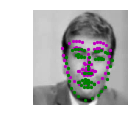

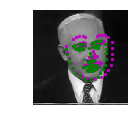

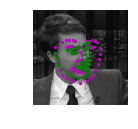

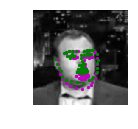

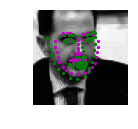

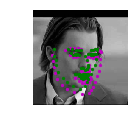

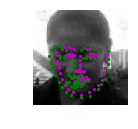

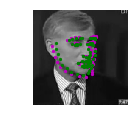

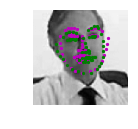

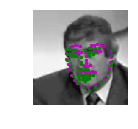

In [210]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [169]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!